Модель для определения Трояна, исходя из сетевых признаков

In [407]:
# Импортируем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Сразу удаляем ненужные фичи

In [408]:
dataset = pd.read_csv('Trojan_Detection.csv')
dataset = dataset.drop(['Unnamed: 0', 'Flow ID', ' Timestamp'], axis=1)

# Получить длину датасета
num_rows = dataset.shape[0]

print("Длина датасета:", num_rows)


Длина датасета: 177482


In [409]:
dataset.head()

Source IP   Source Port  Destination IP   Destination Port   Protocol  \
0   10.42.0.42         49975   121.14.255.84                 80          6   
1   10.42.0.42         49169   172.217.6.226                443         17   
2   10.42.0.42         37749       10.42.0.1                 53         17   
3   10.42.0.42         41352       10.42.0.1                 53         17   
4  10.42.0.151         44353   107.22.241.77                443          6   

    Flow Duration   Total Fwd Packets   Total Backward Packets  \
0        10743584                   4                        4   
1          254217                   6                        7   
2         1023244                   1                        1   
3          286483                   1                        1   
4        65633087                  12                       10   

   Total Length of Fwd Packets   Total Length of Bwd Packets  ...  \
0                        372.0                         672.0  ...   
1                       3191.0                        5246.0  ...   
2                         30.0                         179.0  ...   
3                         40.0                         106.0  ...   
4                        767.0                        5622.0  ...   

    min_seg_size_forward  Active Mean   Active Std   Active Max   Active Min  \
0                     20          0.0          0.0          0.0          0.0   
1                     20          0.0          0.0          0.0          0.0   
2                     32          0.0          0.0          0.0          0.0   
3                     20          0.0          0.0          0.0          0.0   
4                     32     322594.0          0.0     322594.0     322594.0   

    Idle Mean   Idle Std    Idle Max    Idle Min   Class  
0         0.0        0.0         0.0         0.0  Trojan  
1         0.0        0.0         0.0         0.0  Trojan  
2         0.0        0.0         0.0         0.0  Benign  
3         0.0        0.0         0.0         0.0  Trojan  
4  60306983.0        0.0  60306983.0  60306983.0  Benign  

[5 rows x 83 columns]

In [411]:
print(dataset.columns)

Index([' Source IP', ' Source Port', ' Destination IP', ' Destination Port',
       ' Protocol', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Le

In [412]:
# сохраняем только числовые столбцы. Категориальные кодируем в числовые. Целевую переменную (если она есть) - убираем

cols_for_normalization = [ ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' RST Flag Count',
                        ' CWE Flag Count',  ' ECE Flag Count', 'Fwd Avg Bytes/Bulk',
                        ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
                        ' Bwd Avg Packets/Bulk',  'Bwd Avg Bulk Rate', ' act_data_pkt_fwd',
                           ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
                           'Total Length of Fwd Packets',' Total Length of Bwd Packets',
  ' Fwd Packet Length Max', ' Fwd Packet Length Min',
  ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
  'Bwd Packet Length Max', ' Bwd Packet Length Min',
  ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
  ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
  ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
  ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
  ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
  ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
  ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
  ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
  ' Down/Up Ratio', ' Average Packet Size', ' Avg Fwd Segment Size',
  ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets',
  ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
  'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
  ' min_seg_size_forward', 'Active Mean',
  ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
  ' Idle Max', ' Idle Min']

In [413]:
# Нормализовать количественные признаки
scaler = StandardScaler()
dataset[cols_for_normalization] = scaler.fit_transform(dataset[cols_for_normalization])
dataset.head()

Source IP   Source Port  Destination IP   Destination Port   Protocol  \
0   10.42.0.42         49975   121.14.255.84                 80          6   
1   10.42.0.42         49169   172.217.6.226                443         17   
2   10.42.0.42         37749       10.42.0.1                 53         17   
3   10.42.0.42         41352       10.42.0.1                 53         17   
4  10.42.0.151         44353   107.22.241.77                443          6   

    Flow Duration   Total Fwd Packets   Total Backward Packets  \
0       -0.038628           -0.092527                -0.055528   
1       -0.494134           -0.025086                -0.027333   
2       -0.460739           -0.193689                -0.083723   
3       -0.492733           -0.193689                -0.083723   
4        2.344980            0.177238                 0.000862   

   Total Length of Fwd Packets   Total Length of Bwd Packets  ...  \
0                    -0.072645                     -0.063037  ...   
1                     0.392864                     -0.032898  ...   
2                    -0.129121                     -0.066285  ...   
3                    -0.127469                     -0.066766  ...   
4                    -0.007418                     -0.030421  ...   

    min_seg_size_forward  Active Mean   Active Std   Active Max   Active Min  \
0              -1.172879    -0.182251    -0.082902    -0.183967    -0.168433   
1              -1.172879    -0.182251    -0.082902    -0.183967    -0.168433   
2               0.631082    -0.182251    -0.082902    -0.183967    -0.168433   
3              -1.172879    -0.182251    -0.082902    -0.183967    -0.168433   
4               0.631082     0.231390    -0.082902     0.182973     0.261304   

   Idle Mean   Idle Std   Idle Max   Idle Min   Class  
0  -0.294288  -0.123948  -0.300704  -0.281380  Trojan  
1  -0.294288  -0.123948  -0.300704  -0.281380  Trojan  
2  -0.294288  -0.123948  -0.300704  -0.281380  Benign  
3  -0.294288  -0.123948  -0.300704  -0.281380  Trojan  
4   3.614255  -0.123948   3.404620   3.725794  Benign  

[5 rows x 83 columns]

In [414]:
label_enc = LabelEncoder()
dataset['Class'] = label_enc.fit_transform(dataset['Class'])
dataset[' Source Port'] = label_enc.fit_transform(dataset[' Source Port'])
dataset[' Destination Port'] = label_enc.fit_transform(dataset[' Destination Port'])
dataset[' Protocol'] = label_enc.fit_transform(dataset[' Protocol'])
dataset[' Source IP'] = label_enc.fit_transform(dataset[' Source IP'])
dataset[' Destination IP'] = label_enc.fit_transform(dataset[' Destination IP'])

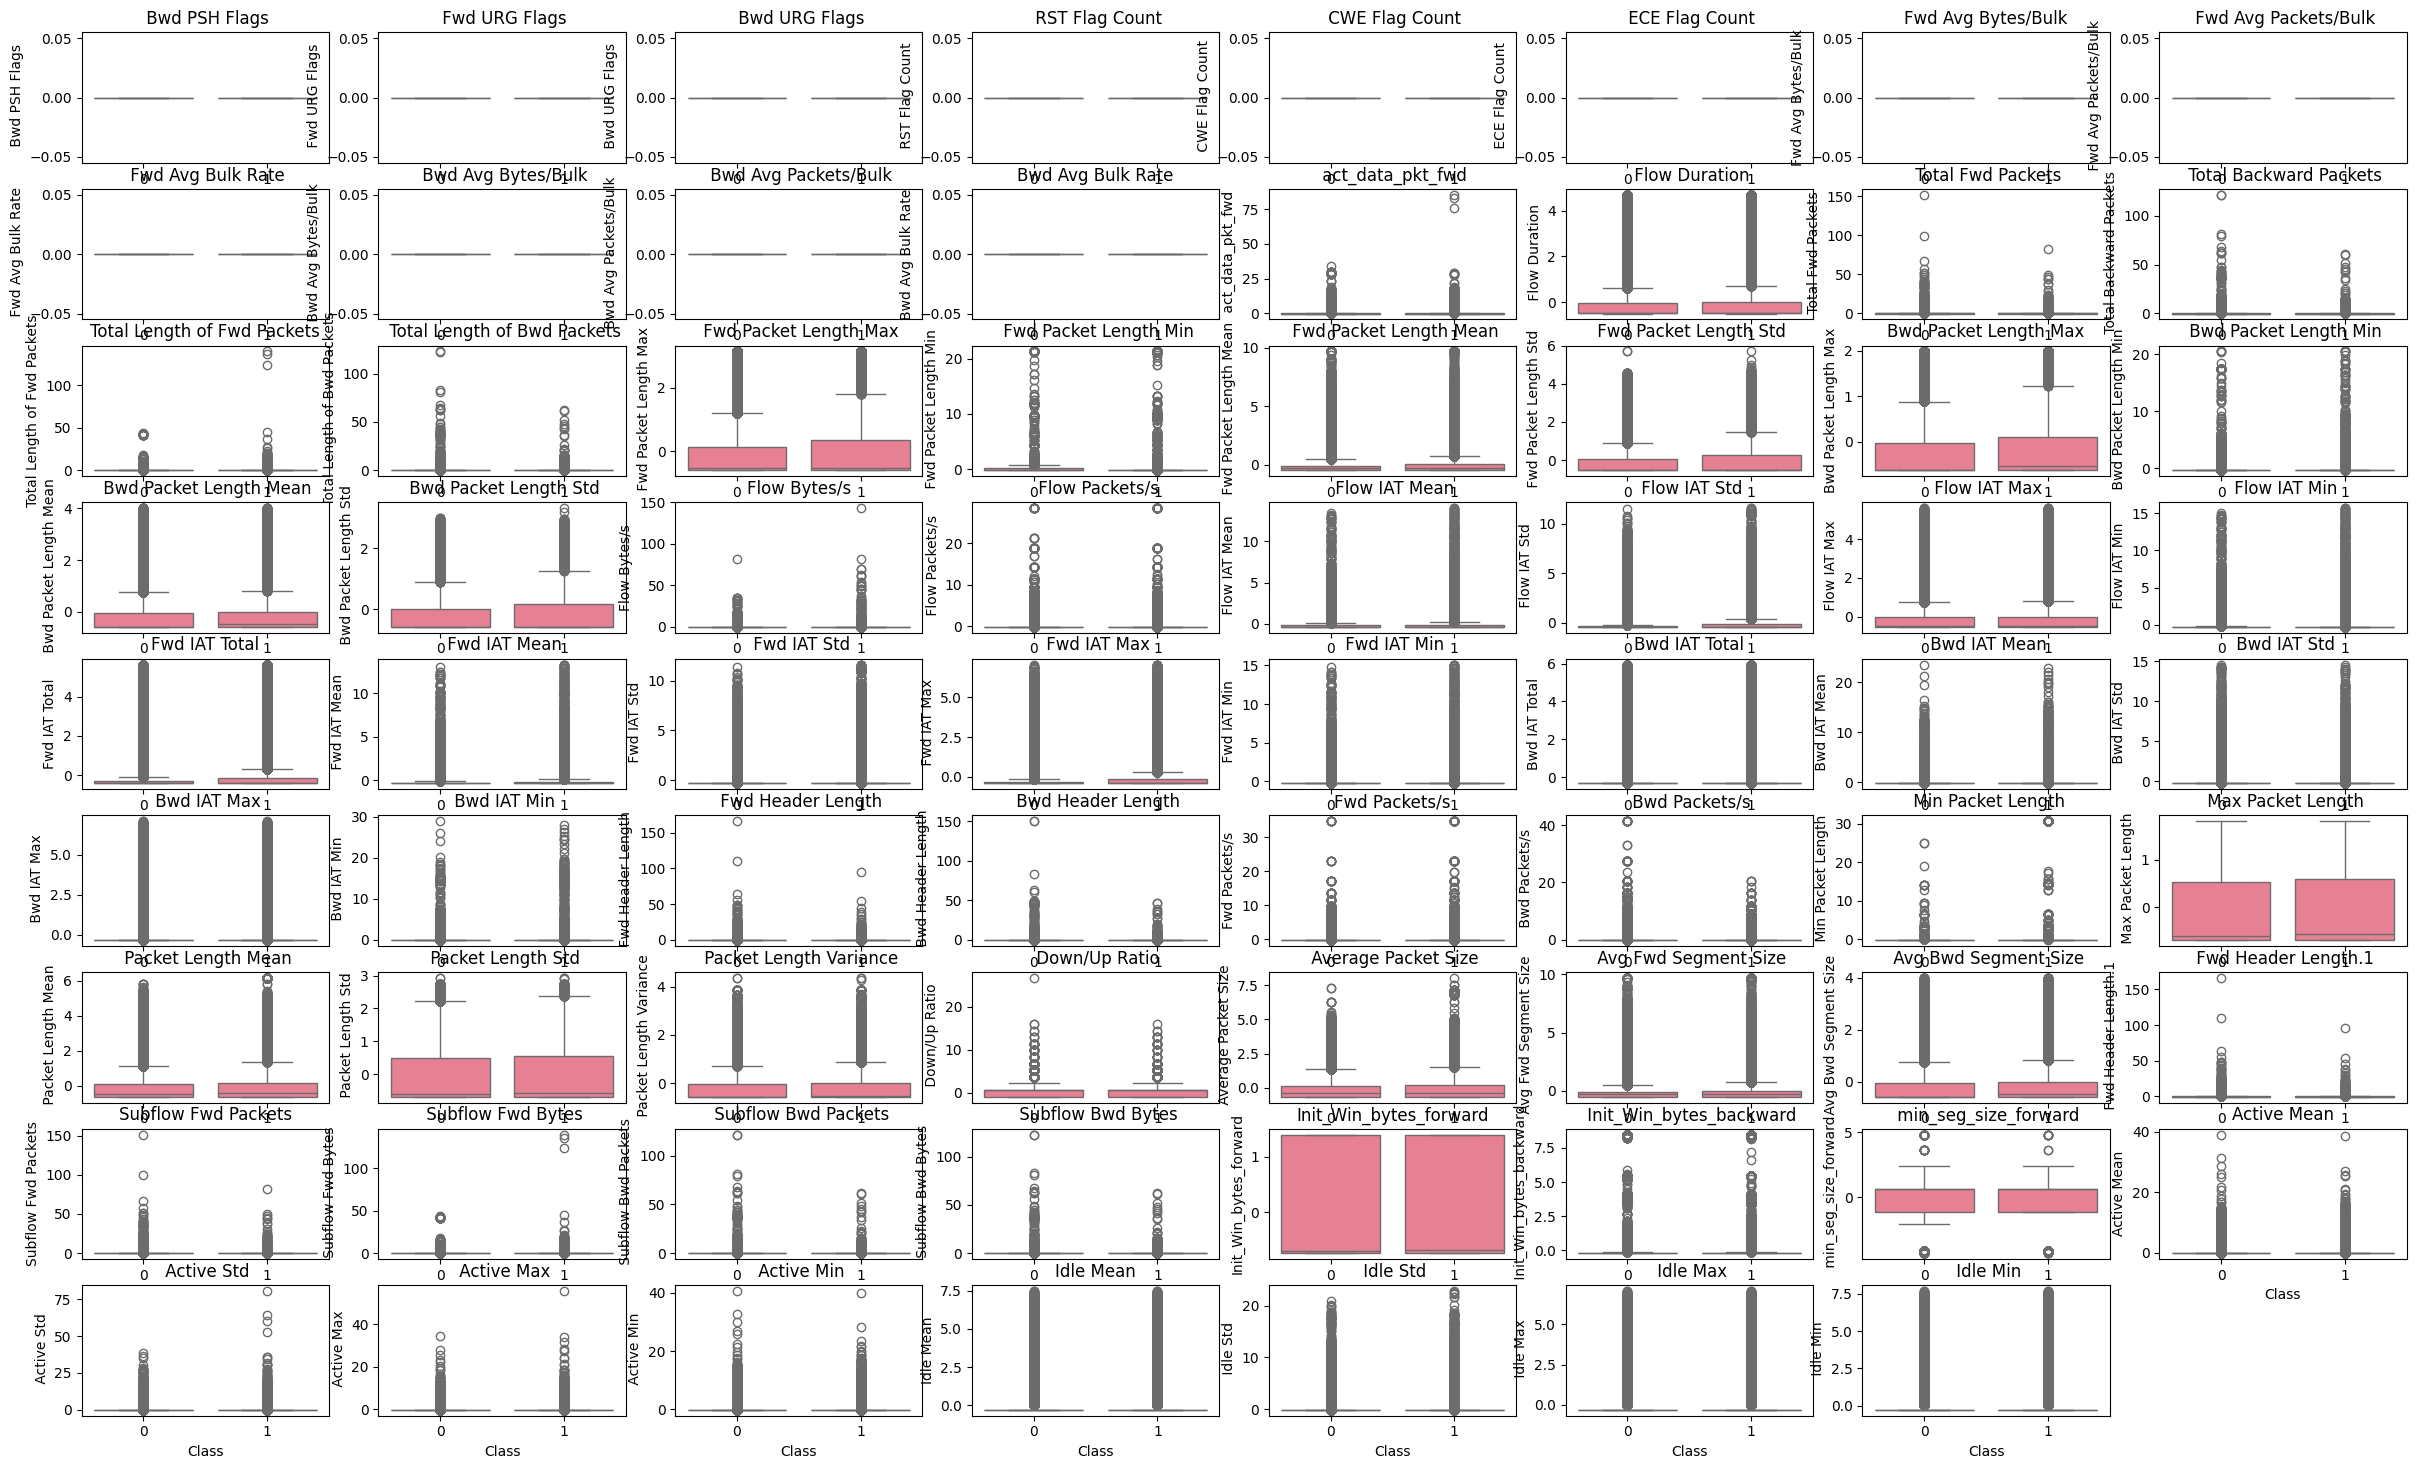

In [415]:
# Создаем boxplot для каждого числового признака
plt.figure(figsize=(30, 20))
for i, feature in enumerate(cols_for_normalization):
    plt.subplot(10, 8, i + 1)  # Настройте количество строк и столбцов в зависимости от количества признаков
    sns.boxplot(x='Class', y=feature, data=dataset)
    plt.title(feature)
plt.show()

In [416]:
# убираем otliers

for column in cols_for_normalization:
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.1 * IQR
    upper_bound = Q3 + 1.1 * IQR

    dataset = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)]

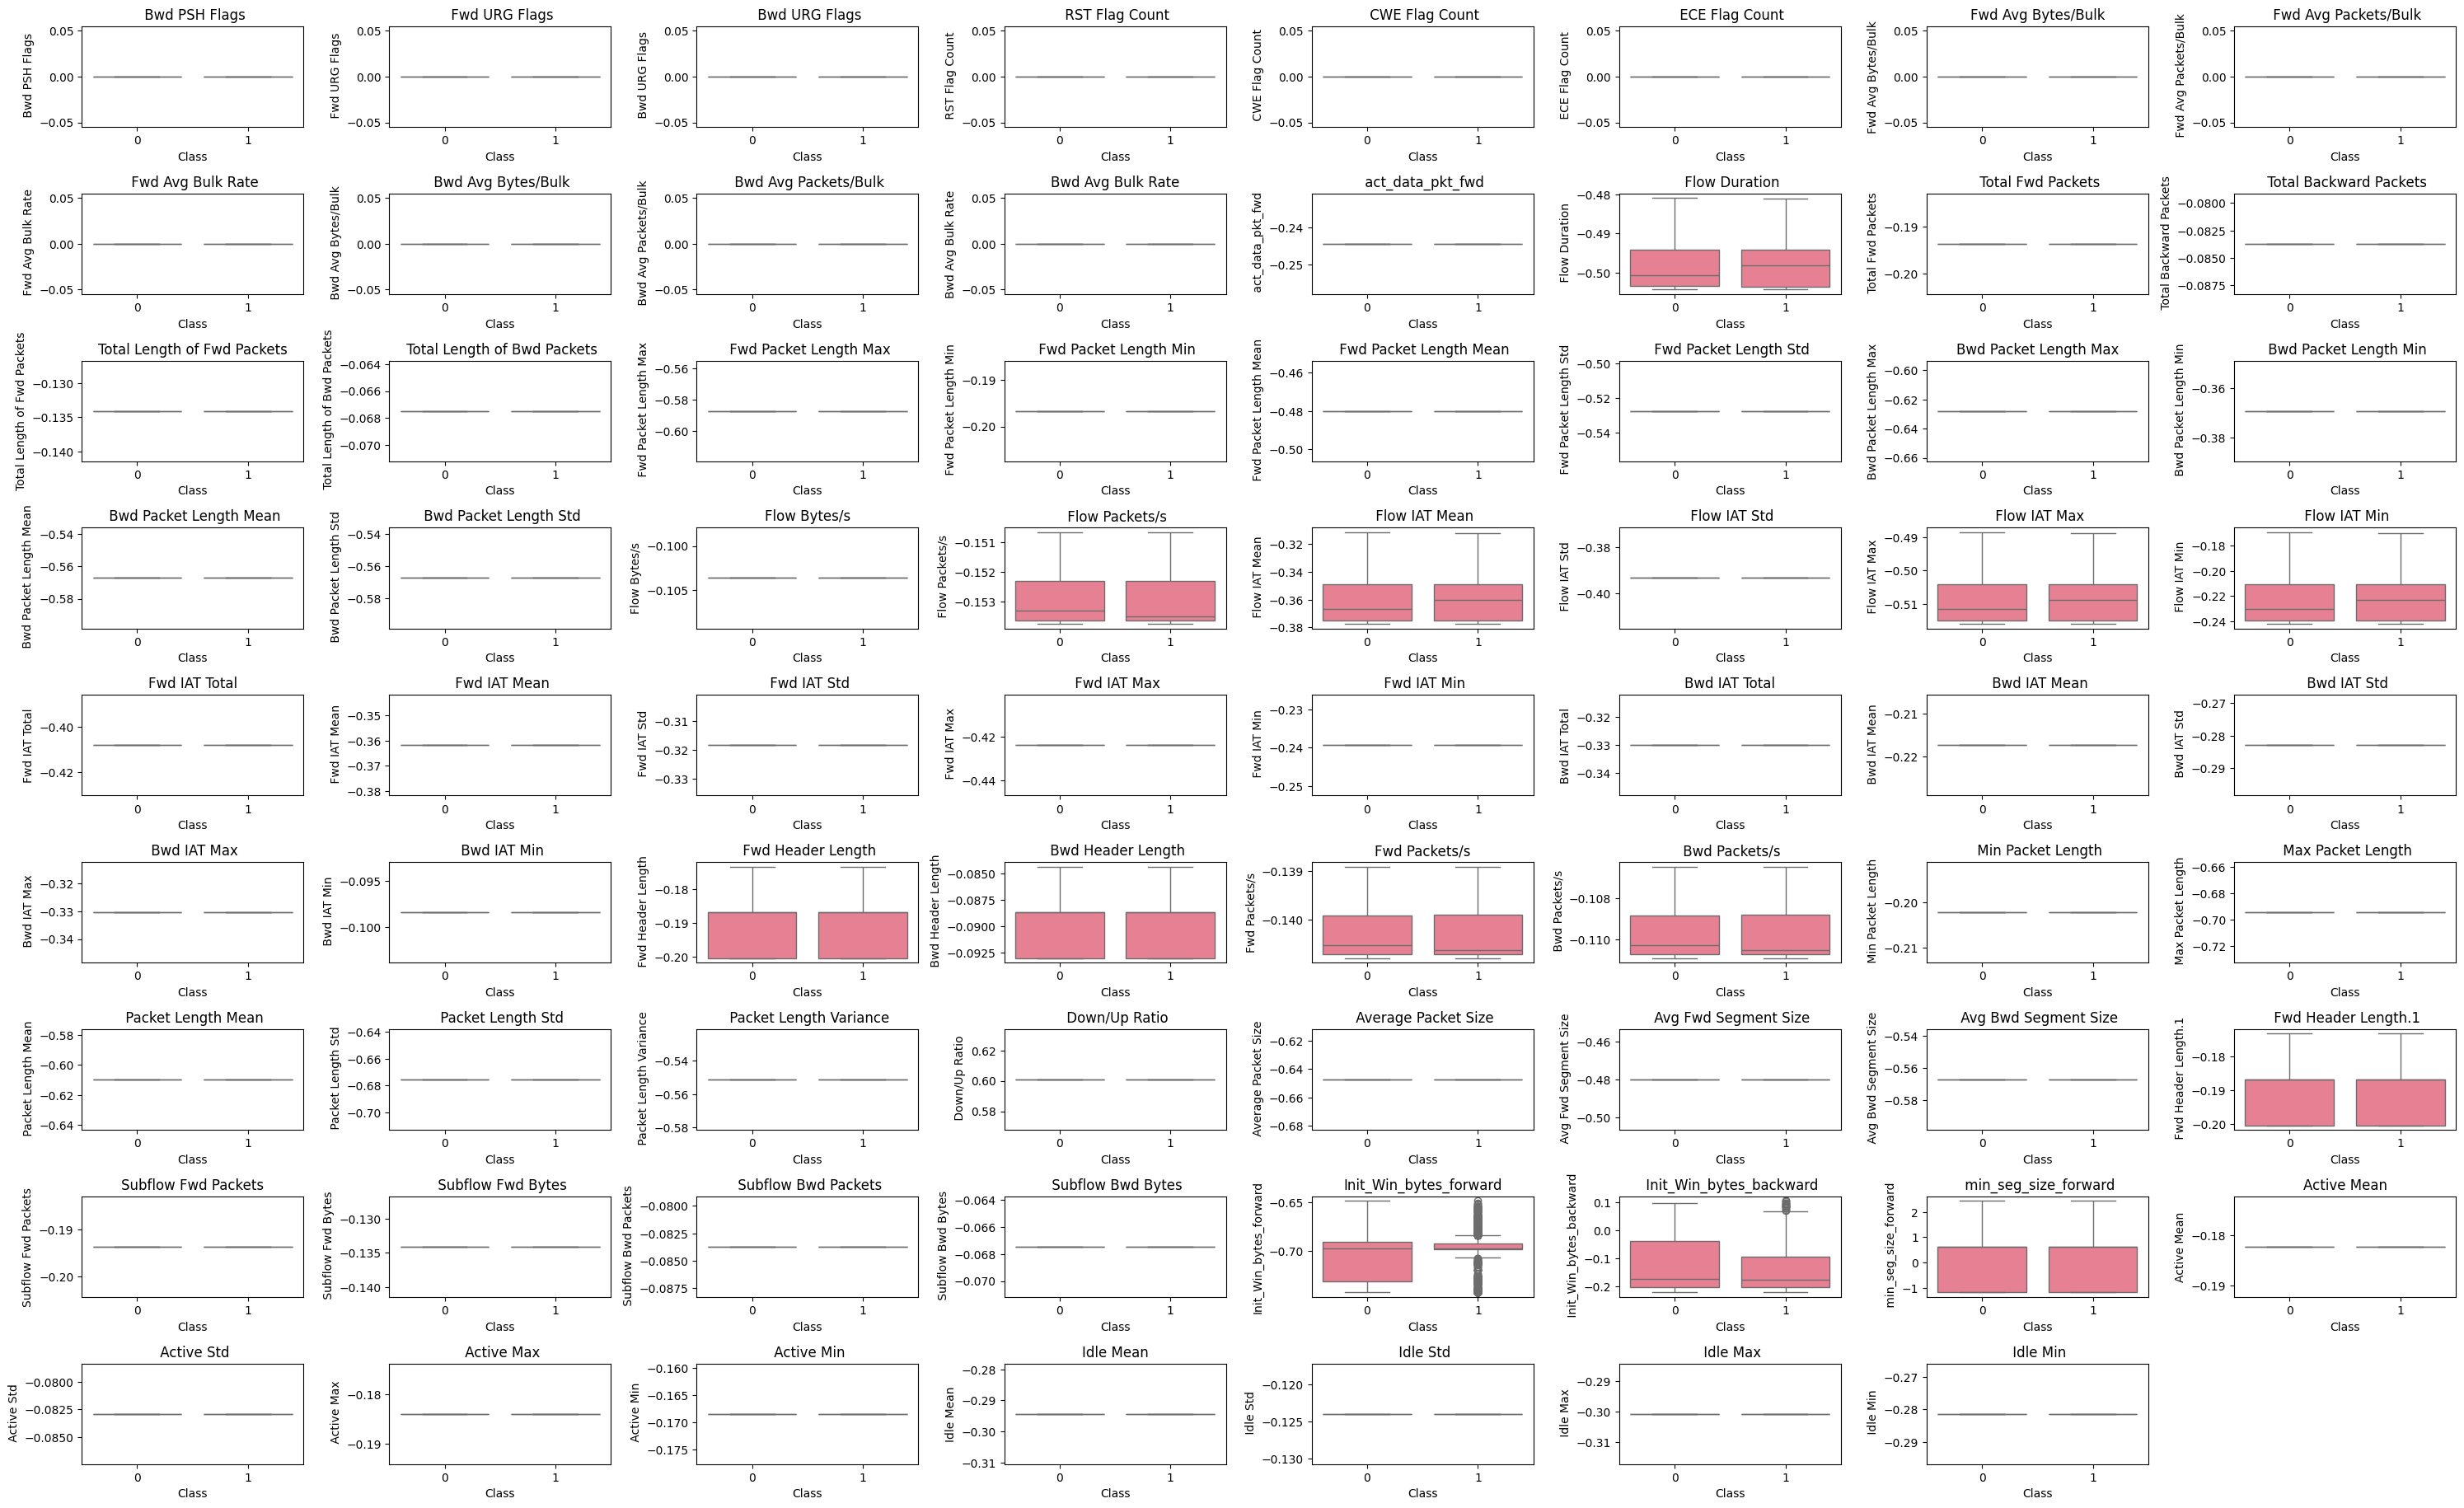

In [417]:
# Создаем boxplot для каждого признака
plt.figure(figsize=(30, 20))
for i, feature in enumerate(cols_for_normalization):
    plt.subplot(10, 8, i + 1)  # Настройте количество строк и столбцов в зависимости от количества признаков
    sns.boxplot(x='Class', y=feature, data=dataset)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [418]:
print(dataset.shape[0])

8166


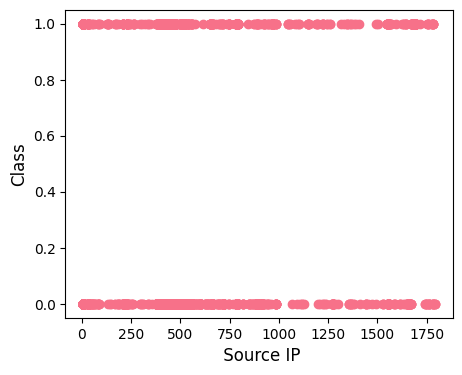

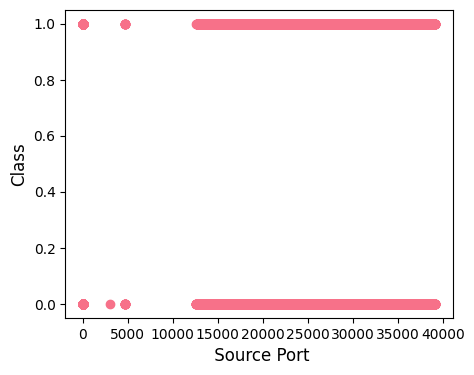

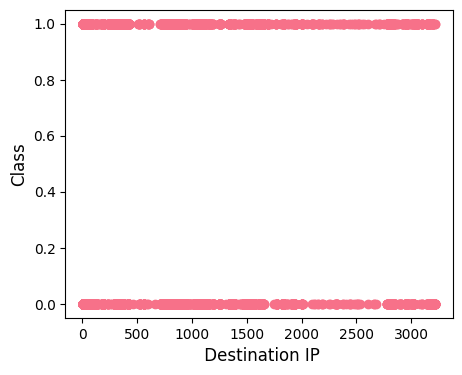

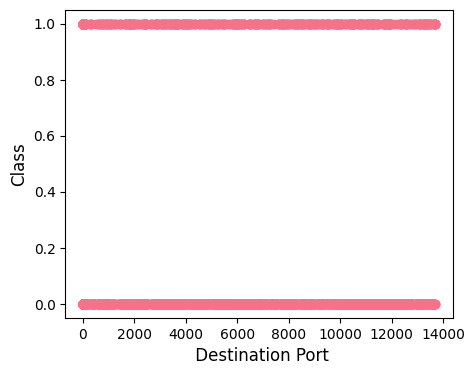

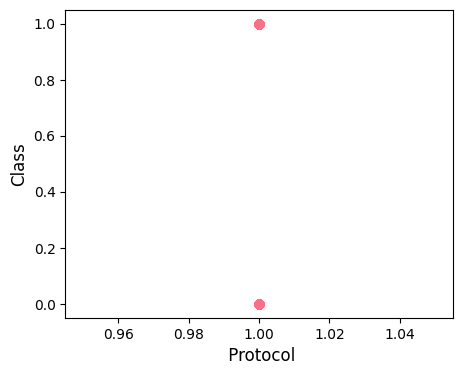

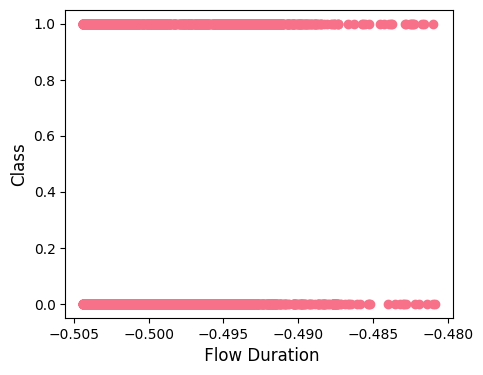

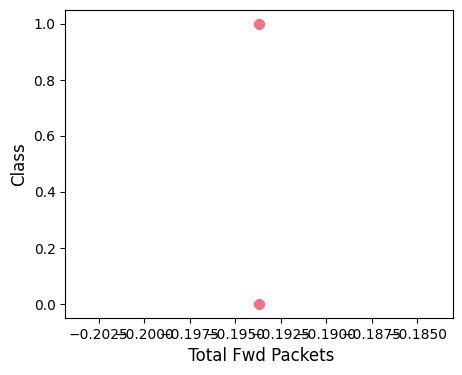

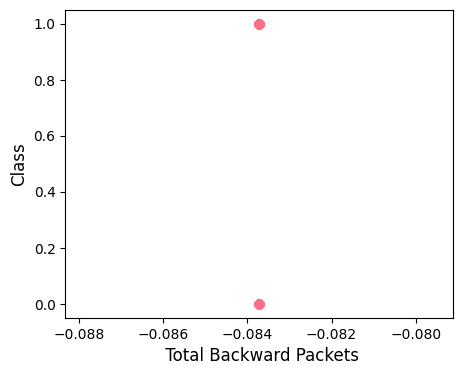

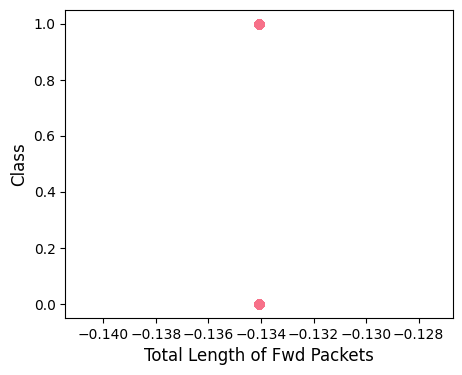

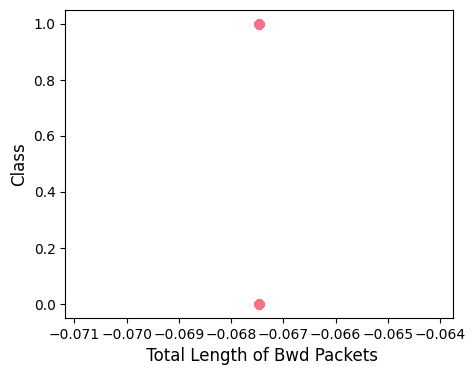

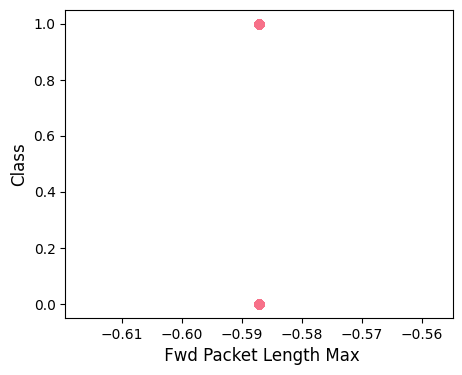

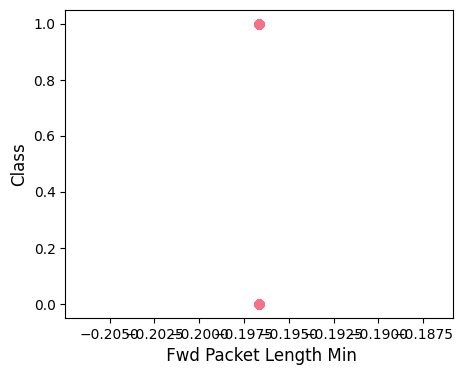

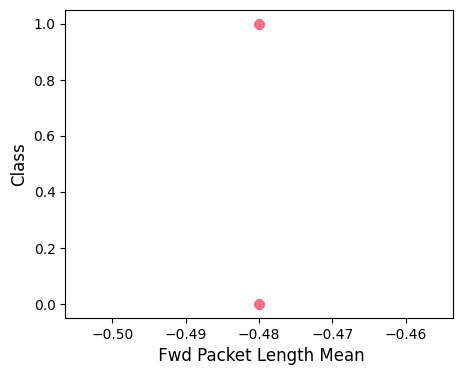

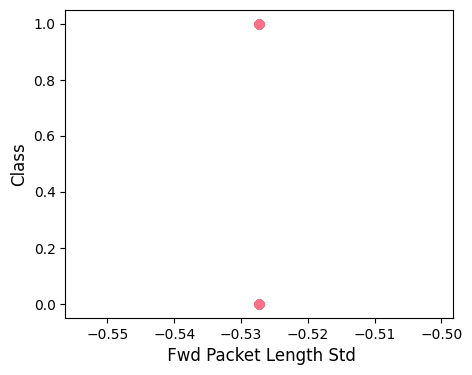

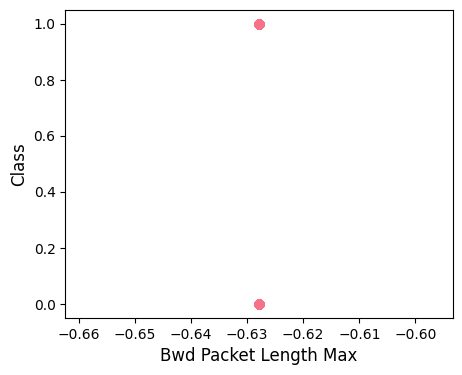

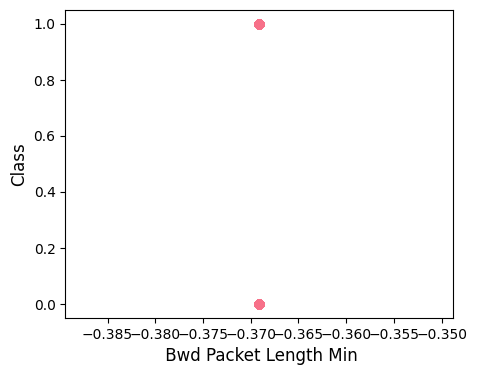

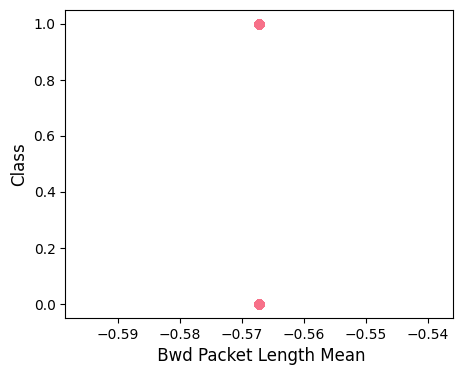

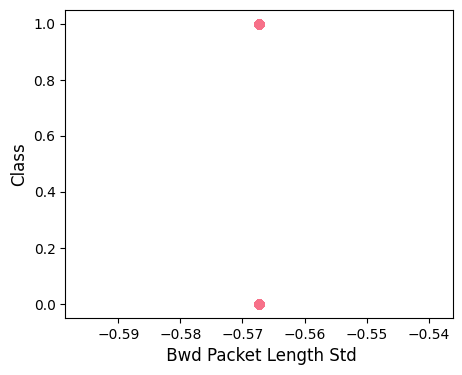

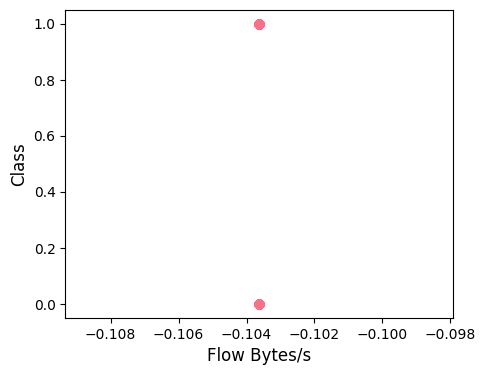

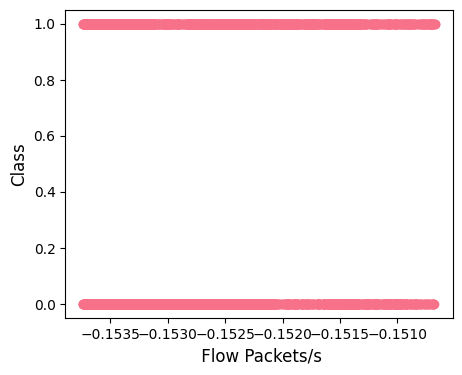

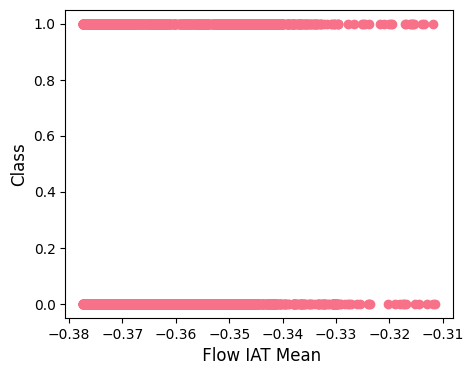

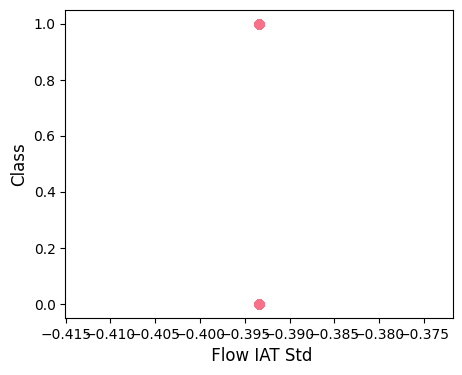

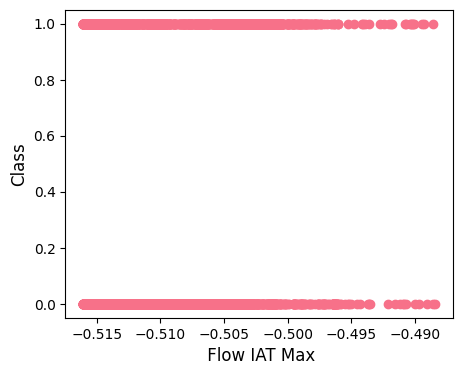

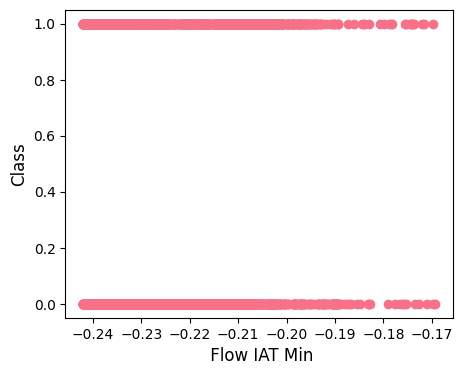

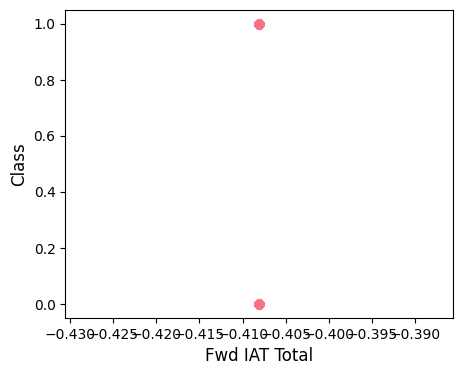

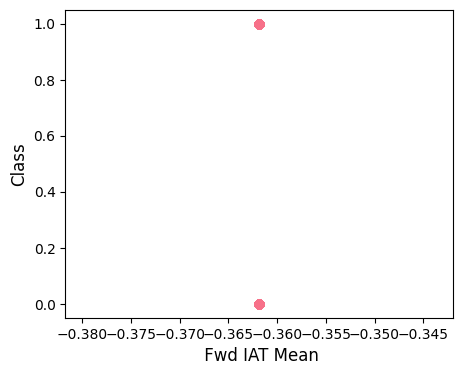

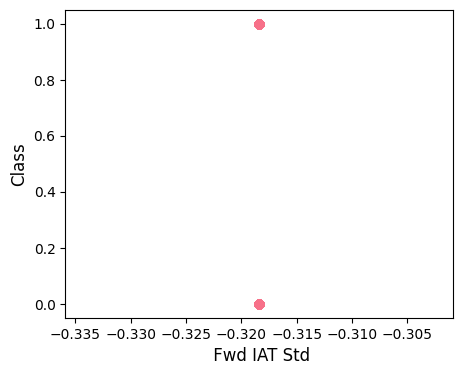

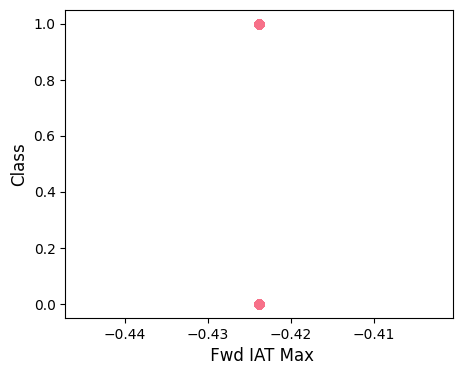

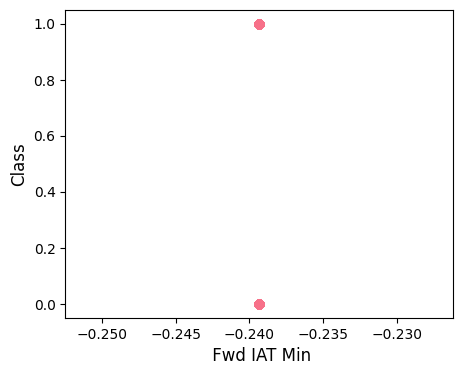

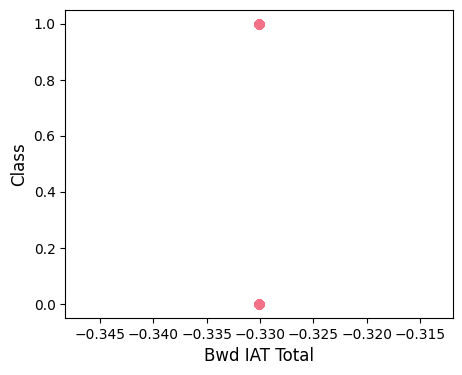

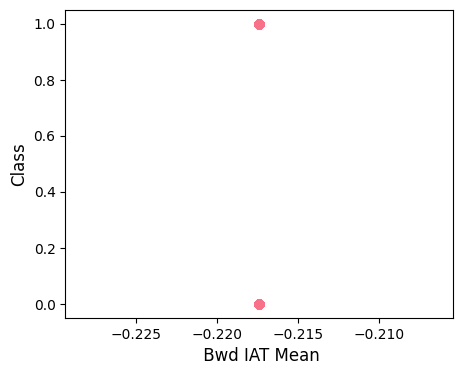

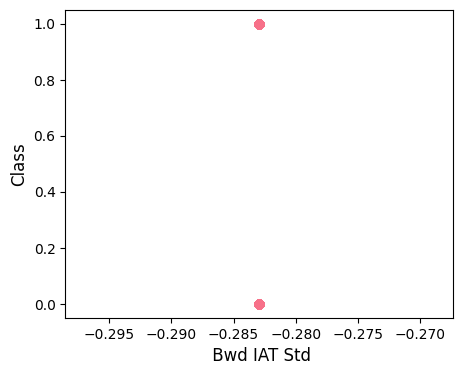

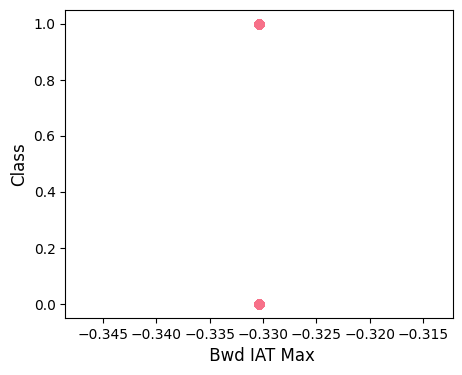

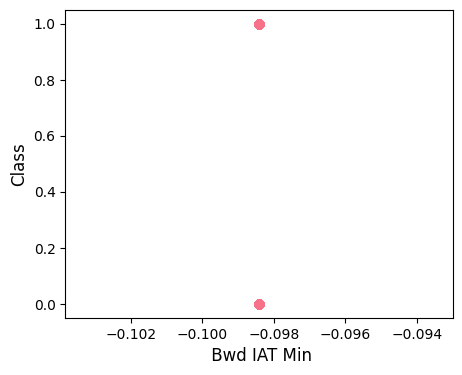

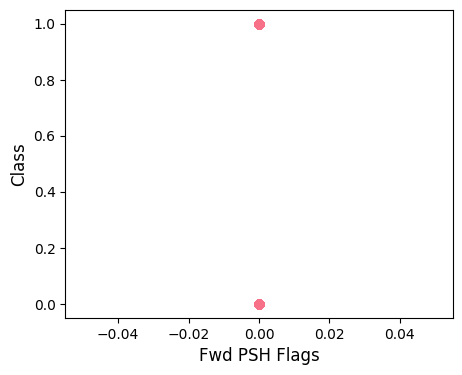

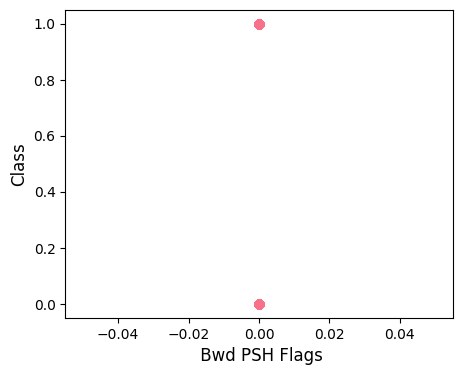

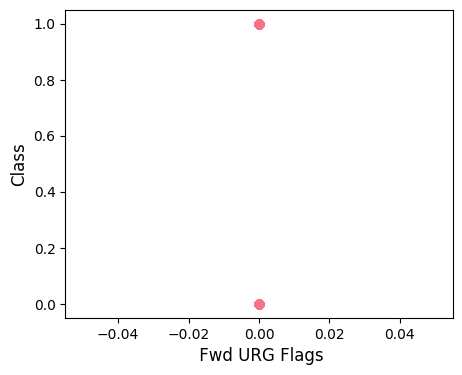

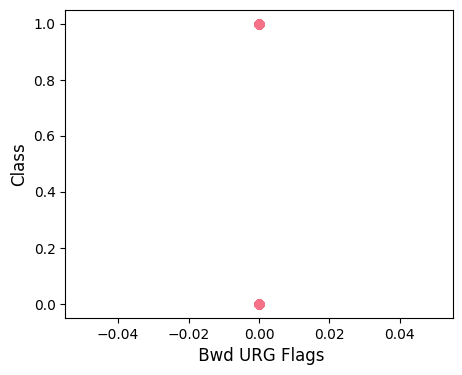

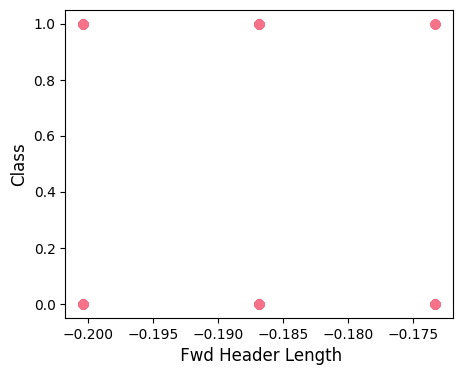

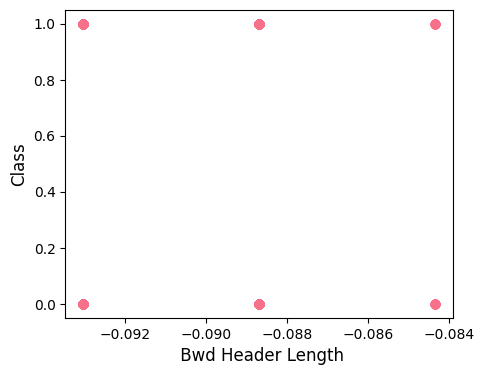

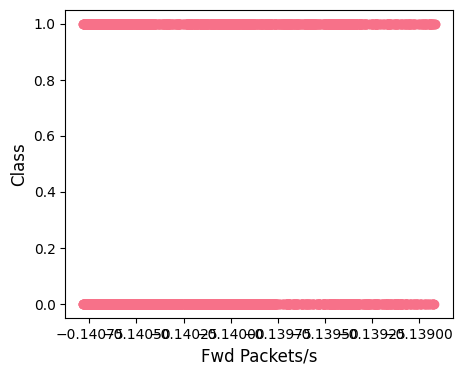

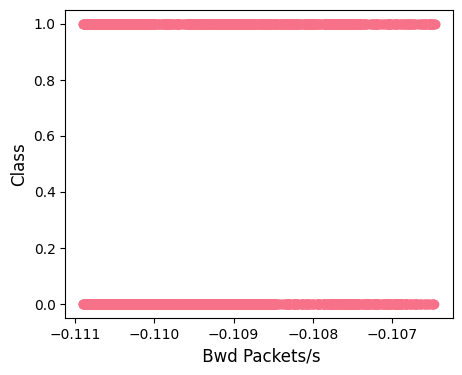

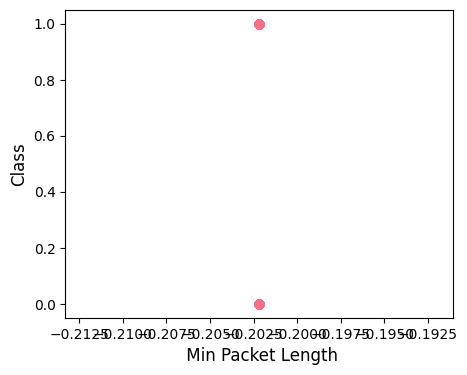

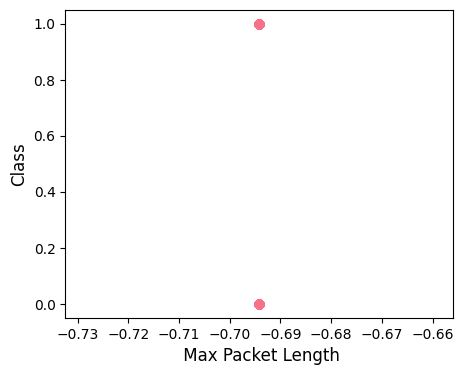

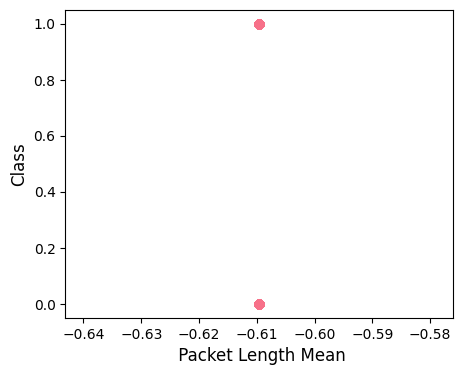

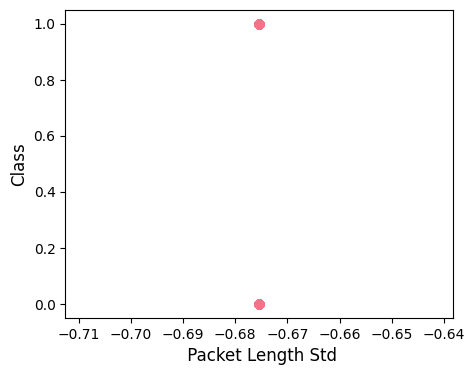

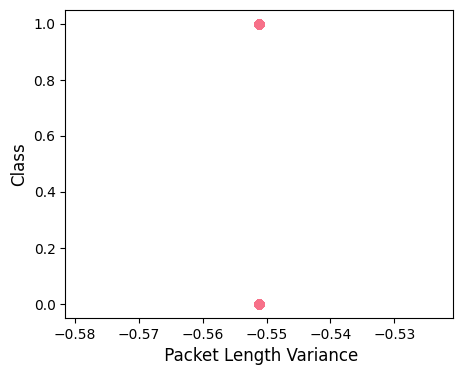

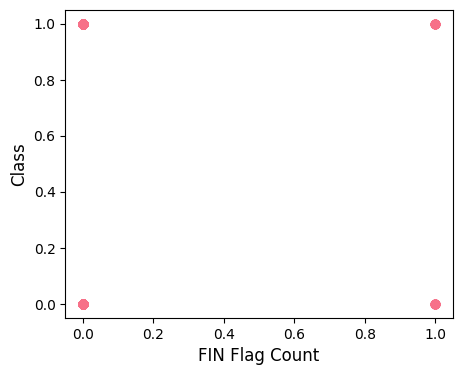

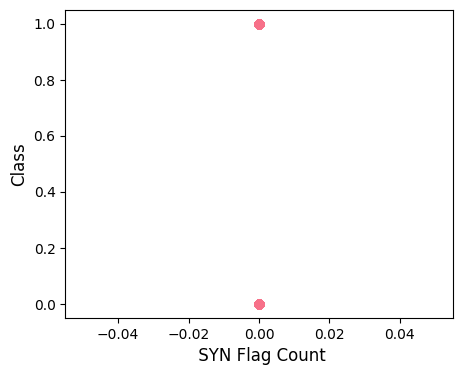

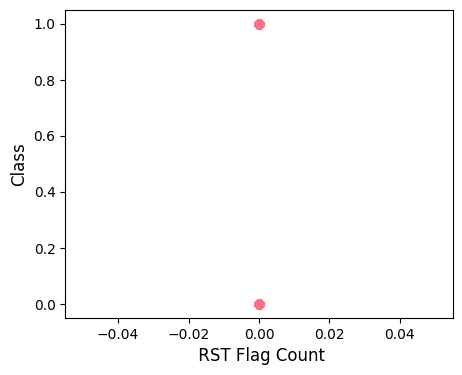

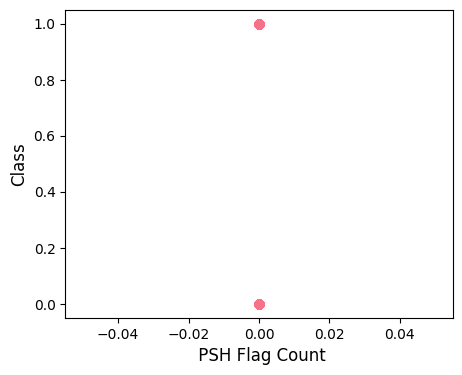

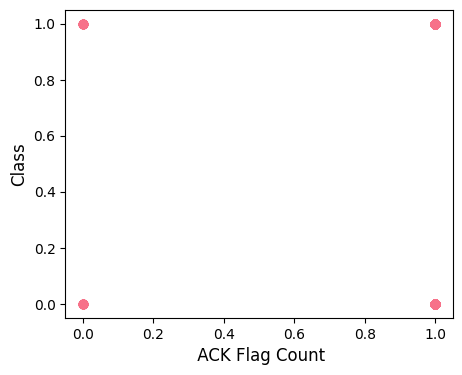

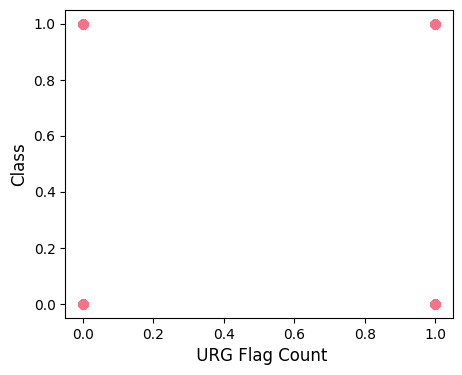

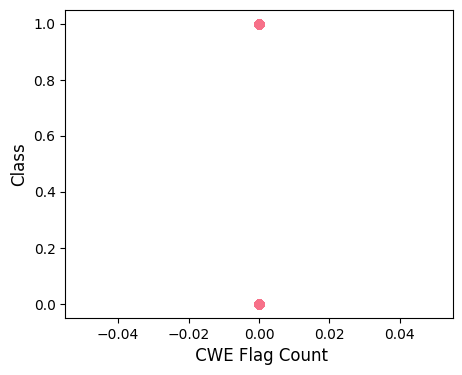

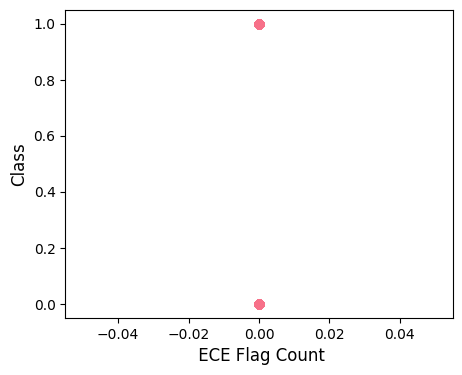

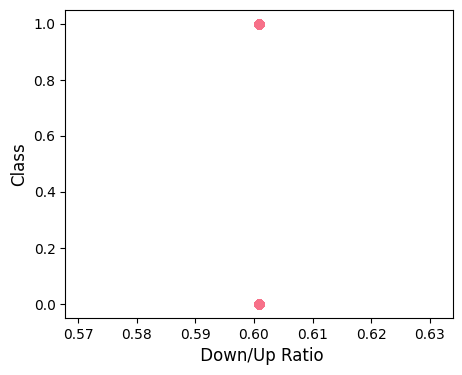

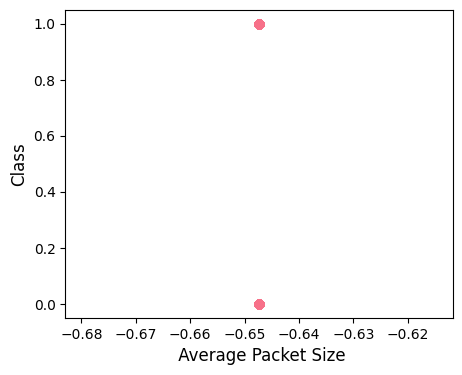

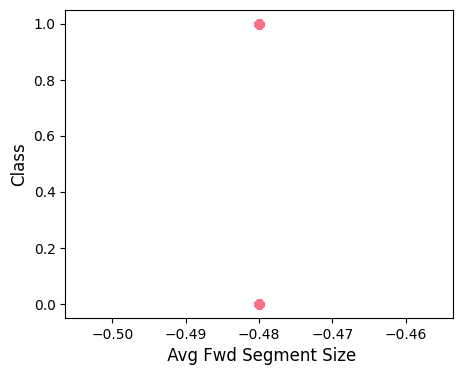

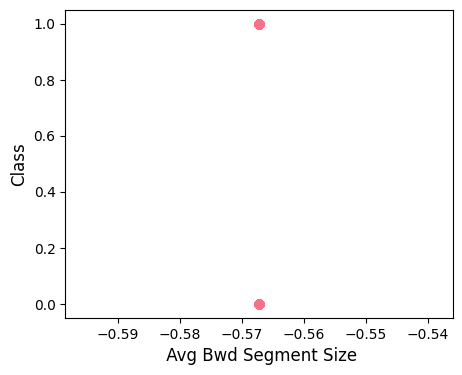

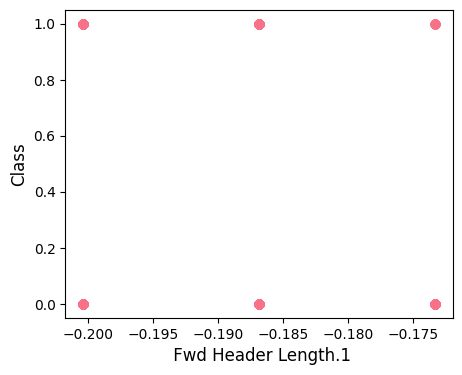

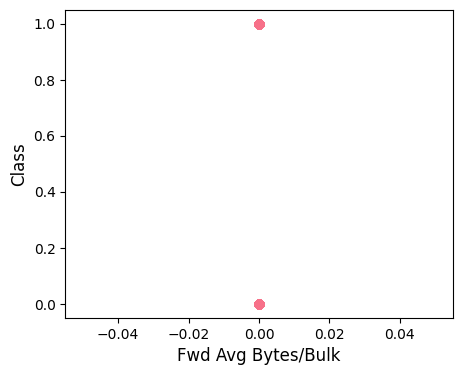

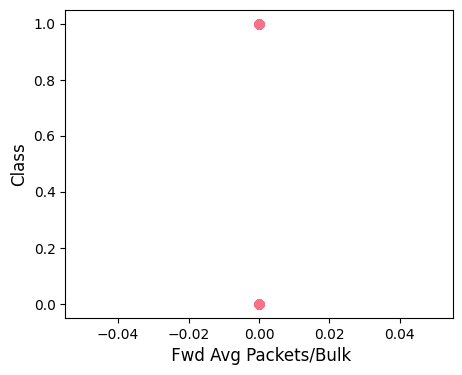

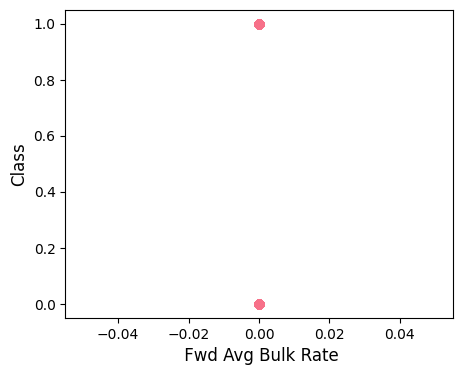

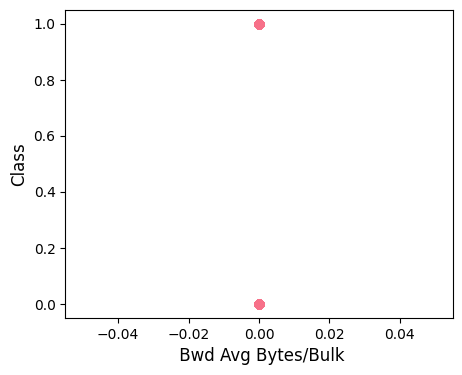

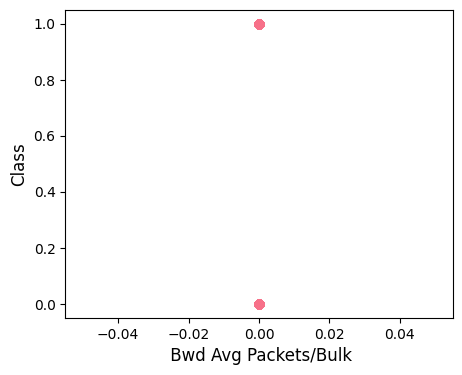

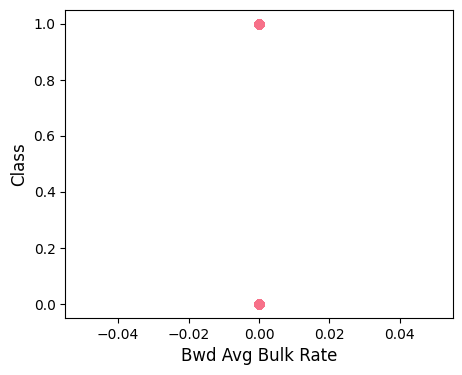

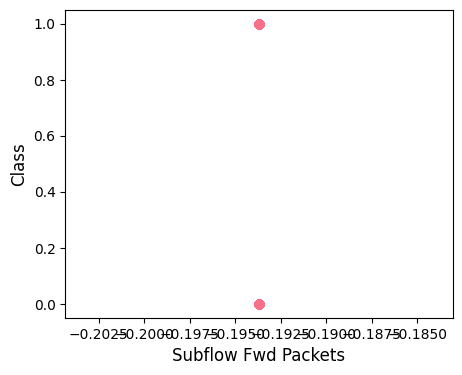

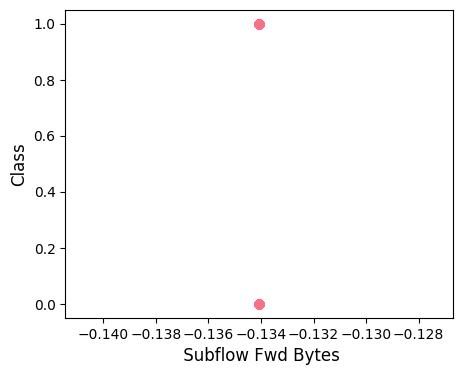

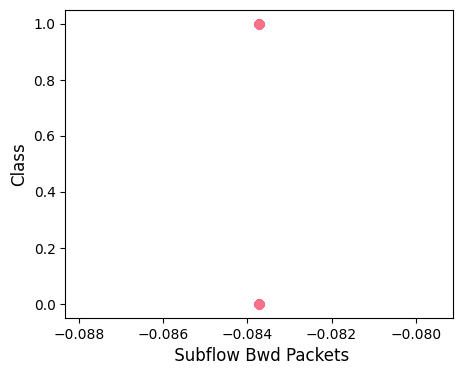

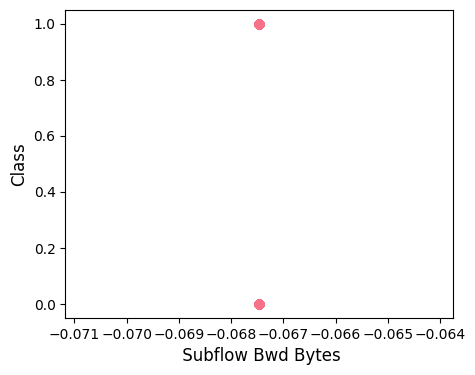

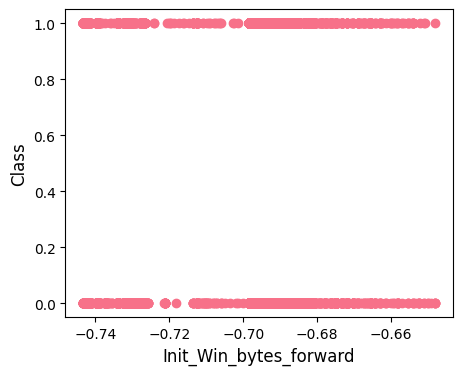

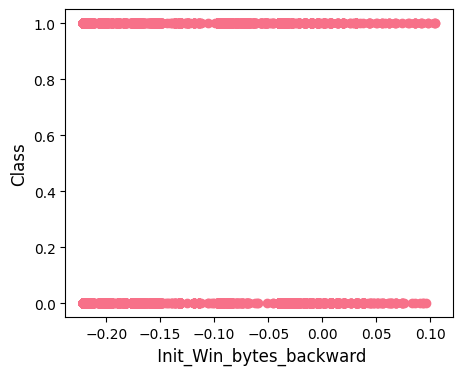

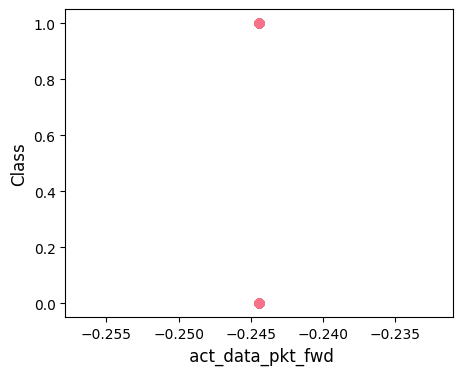

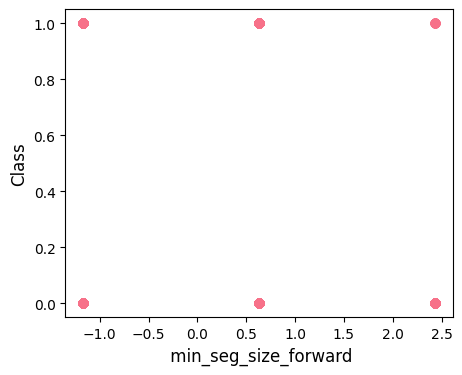

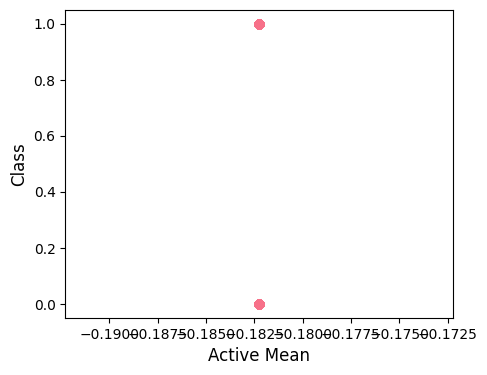

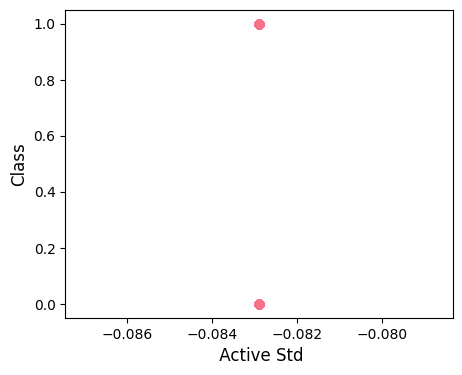

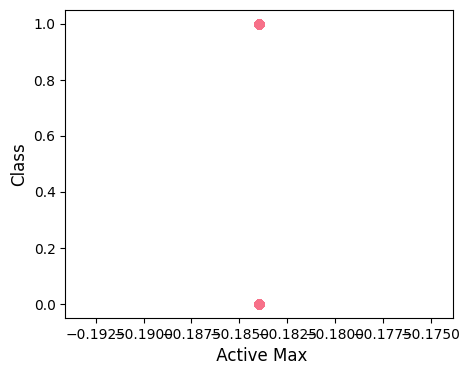

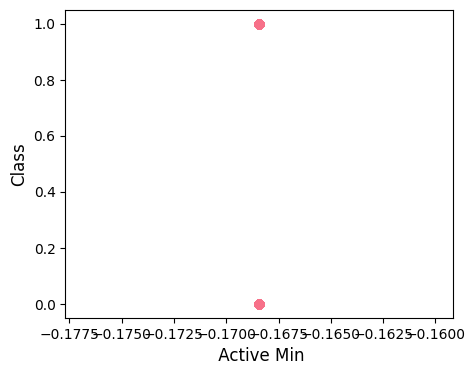

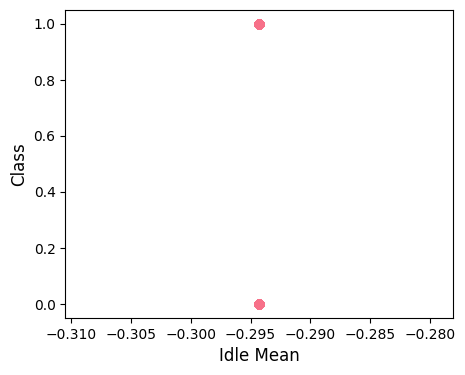

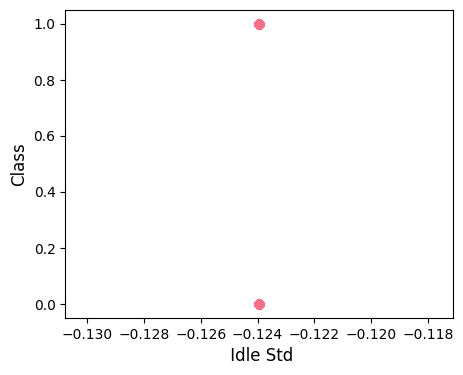

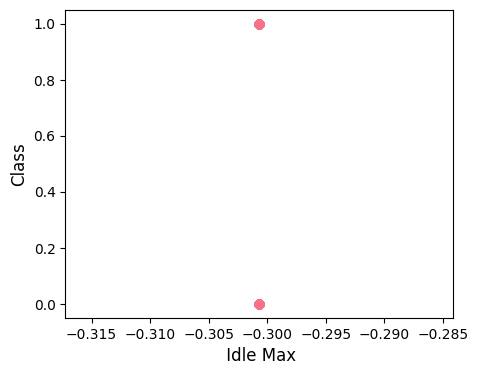

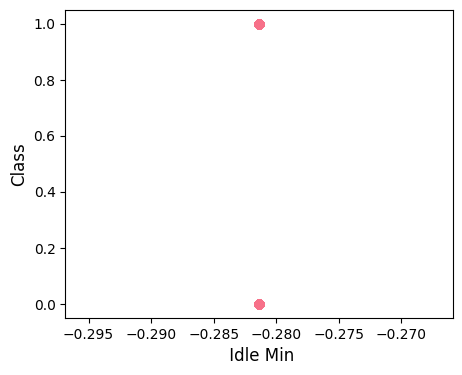

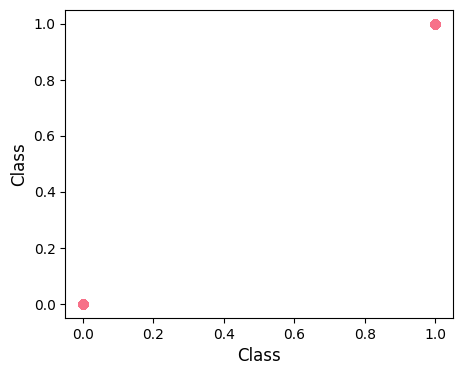

In [419]:
# нарисуем диаграммы рассеяния, чтобы лучше понять, как признаки (фичи) связаны с целевой переменной
for index, feature_name in enumerate(dataset.columns):
    plt.figure(figsize=(5, 4))
    plt.scatter(dataset[feature_name], dataset['Class'])  # Замените 'disease' на имя вашего целевого столбца
    plt.ylabel('Class', size=12)
    plt.xlabel(feature_name, size=12)
    plt.show()

Далее посмотрим распределение классов Benign (=0, безопасно) и Trojan (=1, троян)

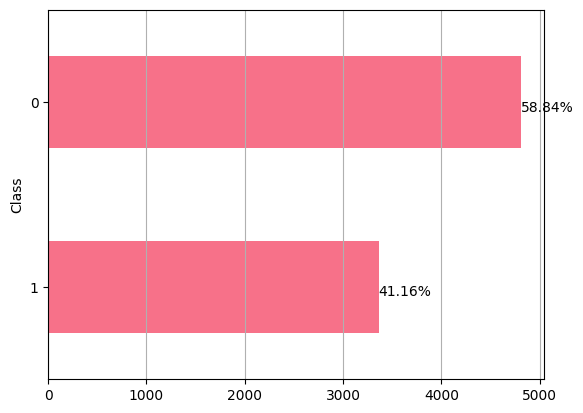

In [420]:
ax = dataset["Class"].value_counts().sort_values().plot(kind="barh")

totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")

plt.show()

Распределение почти равномерное, работы для устанения дисбаланса проводить не будем

In [422]:
num_of_trojan_rows = len(dataset[dataset['Class'] == 1])

In [423]:
dataset = dataset.sample(frac=1)

trojan_dataset = dataset.loc[dataset['Class'] == 1]
benign_dataset = dataset.loc[dataset['Class'] == 0][:num_of_trojan_rows] # берем последние 492 транзакции

normal_distributed_dataset = pd.concat([trojan_dataset, benign_dataset])

# Перемешивание строк датасета
dataset = normal_distributed_dataset.sample(frac=1, random_state=42)

dataset.head()

Source IP   Source Port   Destination IP   Destination Port  \
18045            7         26154             1472                  6   
31095            7         31572               49                  4   
39698          471             4               11               1628   
156196           7         31219              799                  6   
92726            5         26861             1697                  4   

         Protocol   Flow Duration   Total Fwd Packets  \
18045           1       -0.503526           -0.193689   
31095           1       -0.503356           -0.193689   
39698           1       -0.499539           -0.193689   
156196          1       -0.503592           -0.193689   
92726           1       -0.503302           -0.193689   

         Total Backward Packets  Total Length of Fwd Packets  \
18045                 -0.083723                    -0.134075   
31095                 -0.083723                    -0.134075   
39698                 -0.083723                    -0.134075   
156196                -0.083723                    -0.134075   
92726                 -0.083723                    -0.134075   

         Total Length of Bwd Packets  ...   min_seg_size_forward  Active Mean  \
18045                      -0.067465  ...               2.435044    -0.182251   
31095                      -0.067465  ...               0.631082    -0.182251   
39698                      -0.067465  ...               0.631082    -0.182251   
156196                     -0.067465  ...               0.631082    -0.182251   
92726                      -0.067465  ...               0.631082    -0.182251   

         Active Std   Active Max   Active Min  Idle Mean   Idle Std  \
18045     -0.082902    -0.183967    -0.168433  -0.294288  -0.123948   
31095     -0.082902    -0.183967    -0.168433  -0.294288  -0.123948   
39698     -0.082902    -0.183967    -0.168433  -0.294288  -0.123948   
156196    -0.082902    -0.183967    -0.168433  -0.294288  -0.123948   
92726     -0.082902    -0.183967    -0.168433  -0.294288  -0.123948   

         Idle Max   Idle Min  Class  
18045   -0.300704   -0.28138      0  
31095   -0.300704   -0.28138      1  
39698   -0.300704   -0.28138      1  
156196  -0.300704   -0.28138      1  
92726   -0.300704   -0.28138      1  

[5 rows x 83 columns]

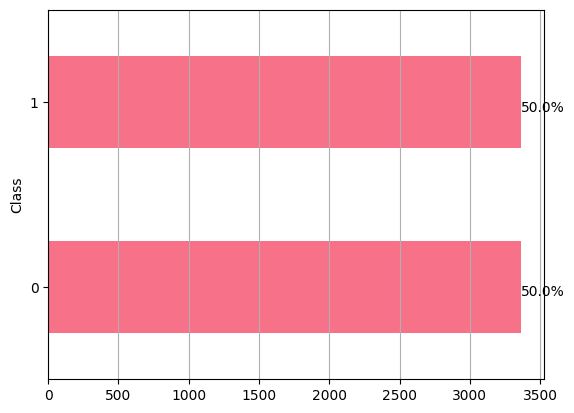

In [424]:
ax = dataset["Class"].value_counts().sort_values().plot(kind="barh")

totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")

plt.show()

Определям важность каждой фичи при помощи RandomForestClassifier

In [425]:
df = dataset.copy() # делаем копию, чтобы не было сюрпризов с исходным набором данных

# Определяем признаки и целевую переменную
y = df['Class']                  # Целевая переменная
X = df.drop(columns=['Class'])  # Все колонки кроме 'Class'

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [426]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
X = X_train.values
y = y_train.values
feature_names = X_train.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

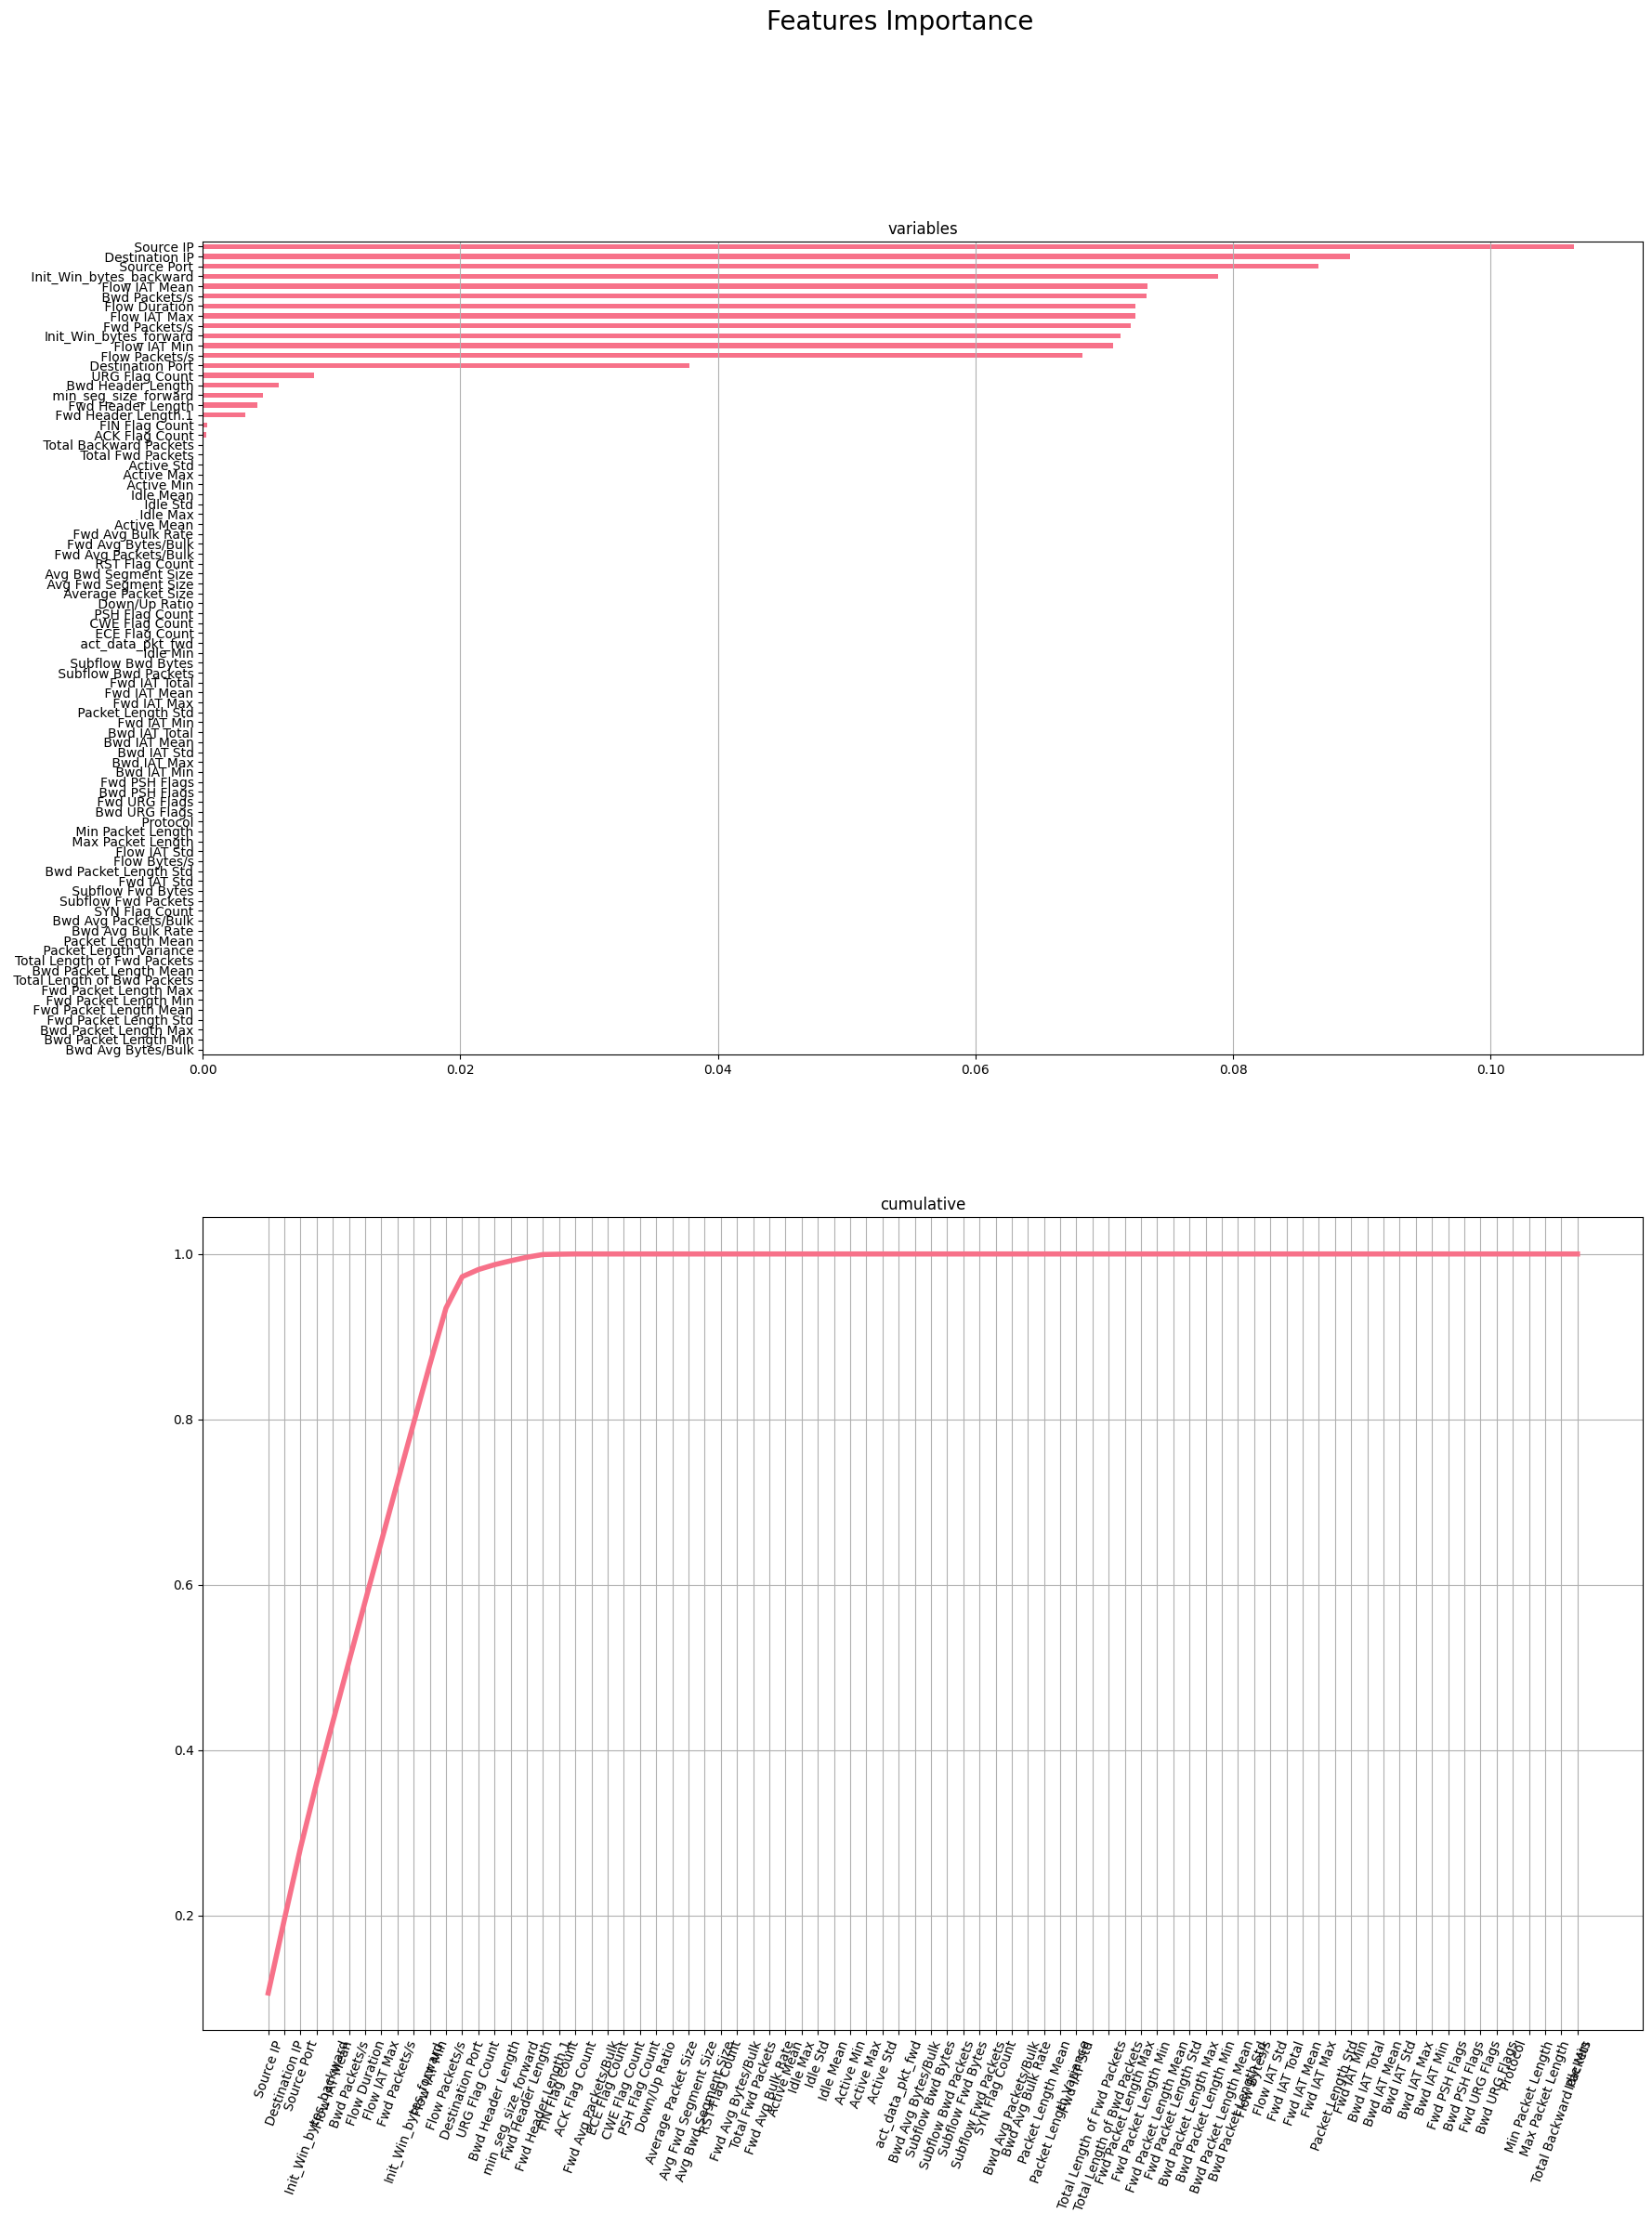

[' Source IP', ' Destination IP', ' Source Port', ' Init_Win_bytes_backward', ' Flow IAT Mean', ' Bwd Packets/s', ' Flow Duration', ' Flow IAT Max', 'Fwd Packets/s', 'Init_Win_bytes_forward', ' Flow IAT Min', ' Flow Packets/s', ' Destination Port', ' URG Flag Count', ' Bwd Header Length']


In [427]:
## Plot
'''
 Формируем надписи для графика

 ticks : подобный массиву, содержащий список местоположений xtick. Передача пустого списка удаляет все xticks. (По желанию)
labels : подобный массиву, содержащий метки для размещения в заданных местах тиков. Этот аргумент может быть передан только в том случае, если также переданы тики. (По желанию)
kwargs : текстовые свойства, которые можно использовать для управления внешним видом меток.
Функция Matplotlib xticks() возвращает:
locs: список местоположений xtick.
labels: список текстовых объектов xlabel
plt.grid - Настройка линий сетки.
axis - Ось, к которой применяются изменения.


'''
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False,figsize=(20,25),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

threshold = 0.99
important_features = dtf_importances[dtf_importances['cumsum'] <= threshold]

important_features_list = important_features.index.tolist()
print(important_features_list)
important_features_list.append('Class')

Исходя из результатов анализа можно сделать выводы, что все фичи после "Total Length of Fwd Packets" нам в принципе не делают никакого значимого вклада.

In [428]:
print(important_features_list)

[' Source IP', ' Destination IP', ' Source Port', ' Init_Win_bytes_backward', ' Flow IAT Mean', ' Bwd Packets/s', ' Flow Duration', ' Flow IAT Max', 'Fwd Packets/s', 'Init_Win_bytes_forward', ' Flow IAT Min', ' Flow Packets/s', ' Destination Port', ' URG Flag Count', ' Bwd Header Length', 'Class']


In [429]:
# Создайте новый датасет с нужными колонками
dataset = dataset[important_features_list]

In [430]:
print(dataset.columns)

Index([' Source IP', ' Destination IP', ' Source Port',
       ' Init_Win_bytes_backward', ' Flow IAT Mean', ' Bwd Packets/s',
       ' Flow Duration', ' Flow IAT Max', 'Fwd Packets/s',
       'Init_Win_bytes_forward', ' Flow IAT Min', ' Flow Packets/s',
       ' Destination Port', ' URG Flag Count', ' Bwd Header Length', 'Class'],
      dtype='object')


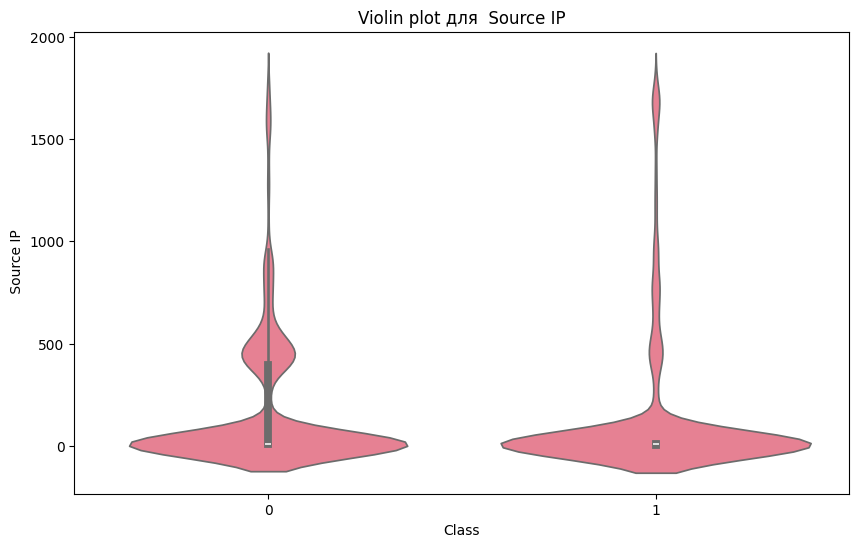

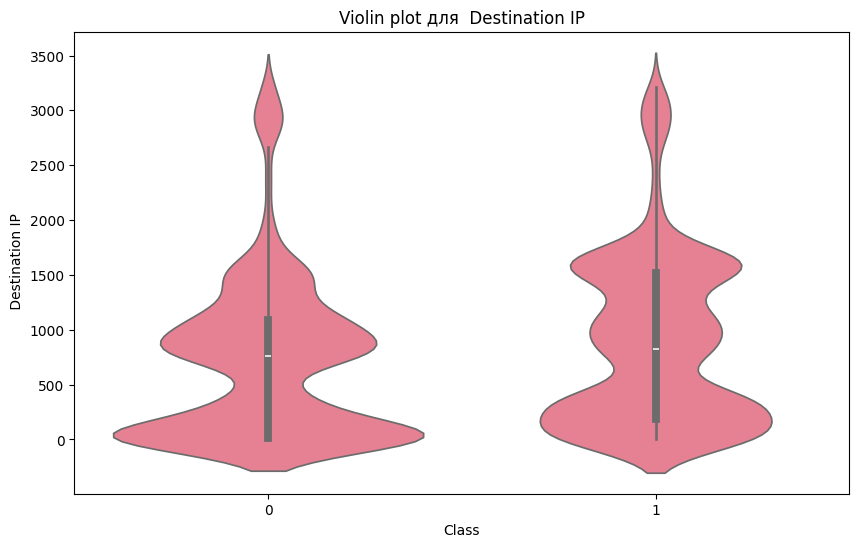

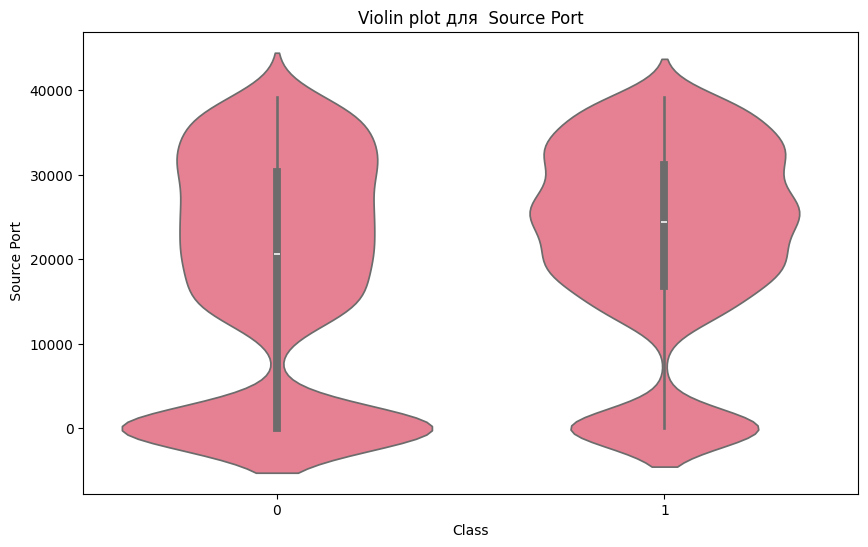

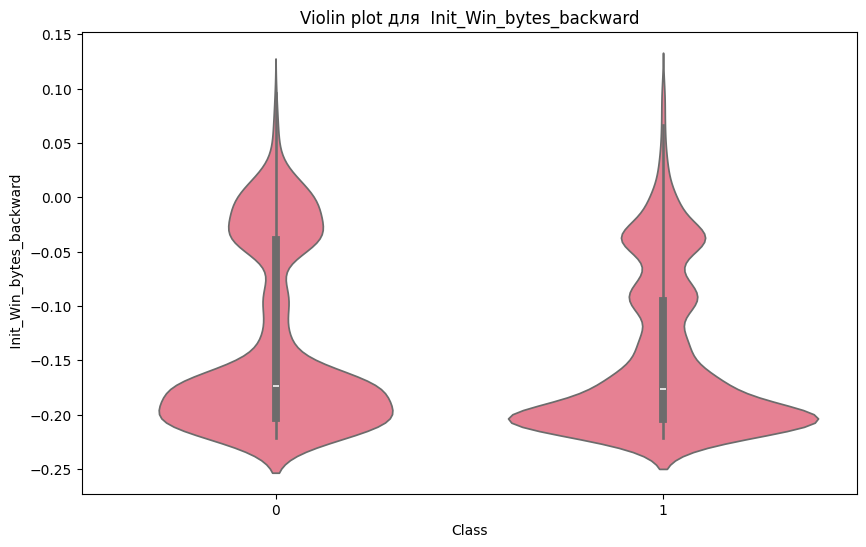

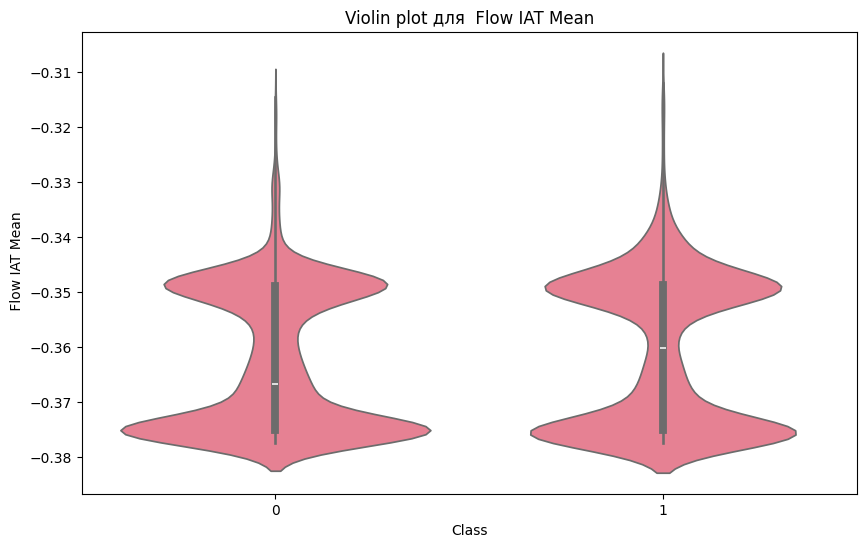

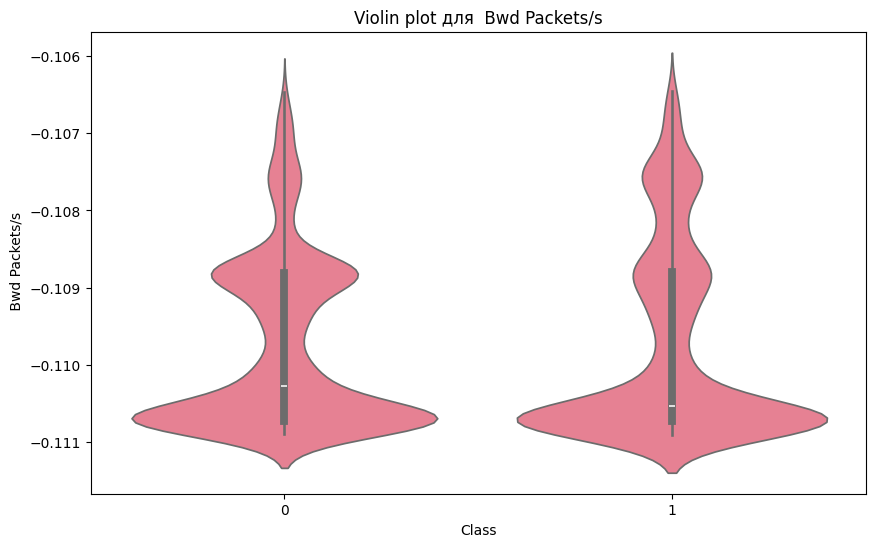

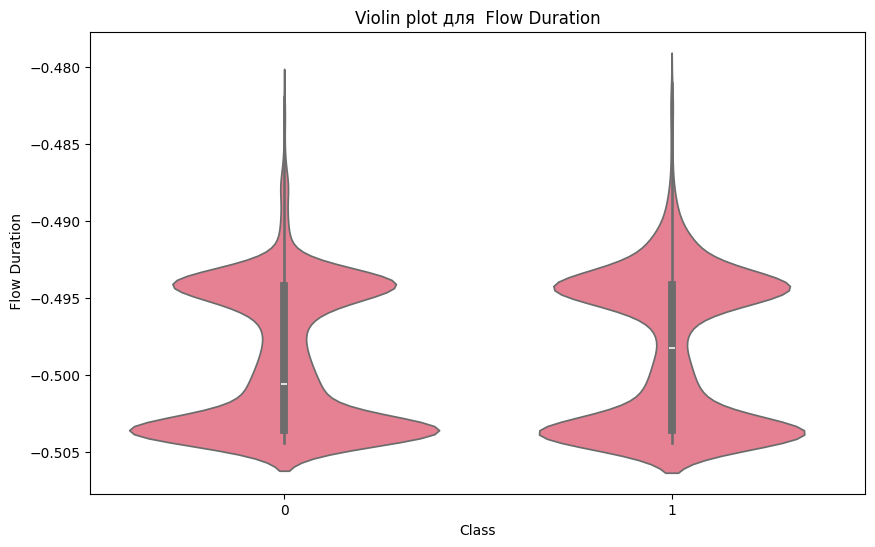

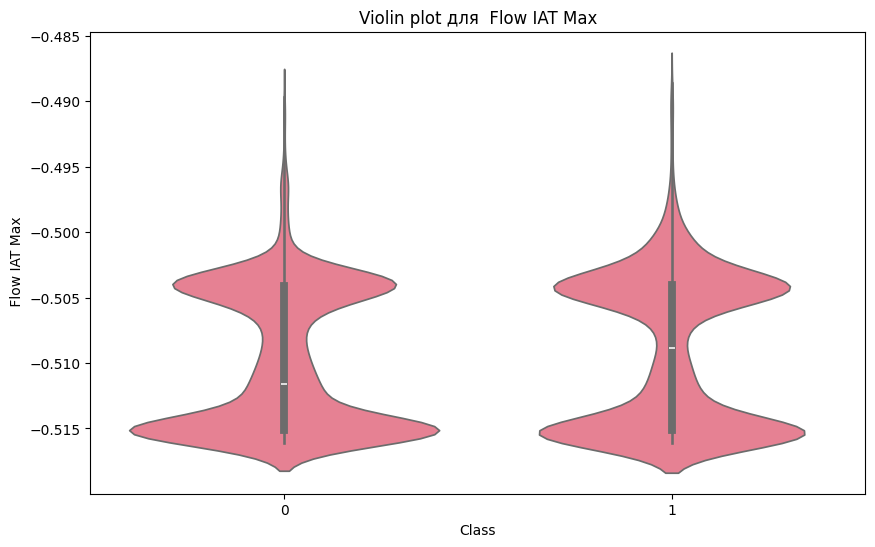

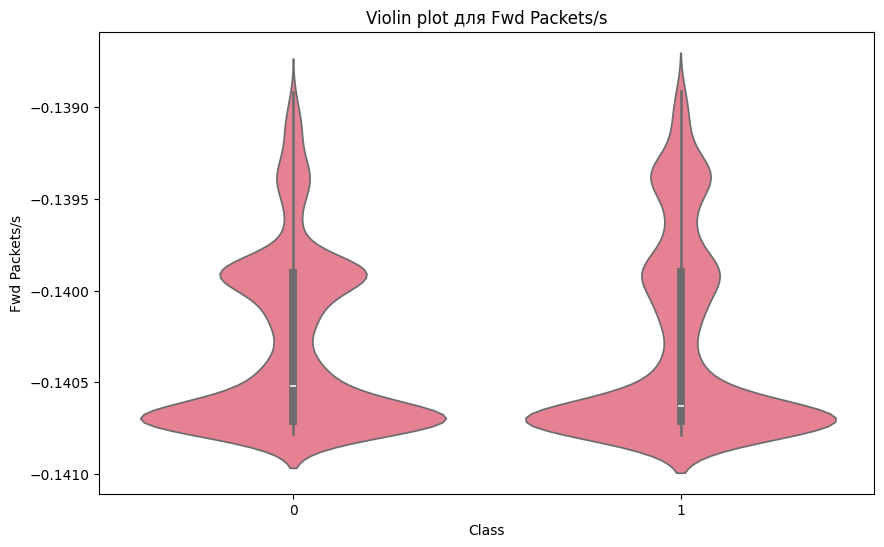

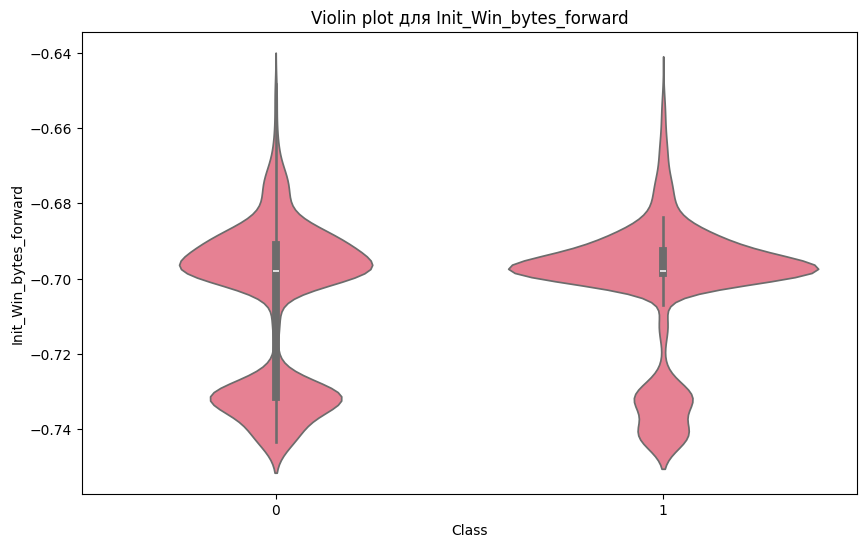

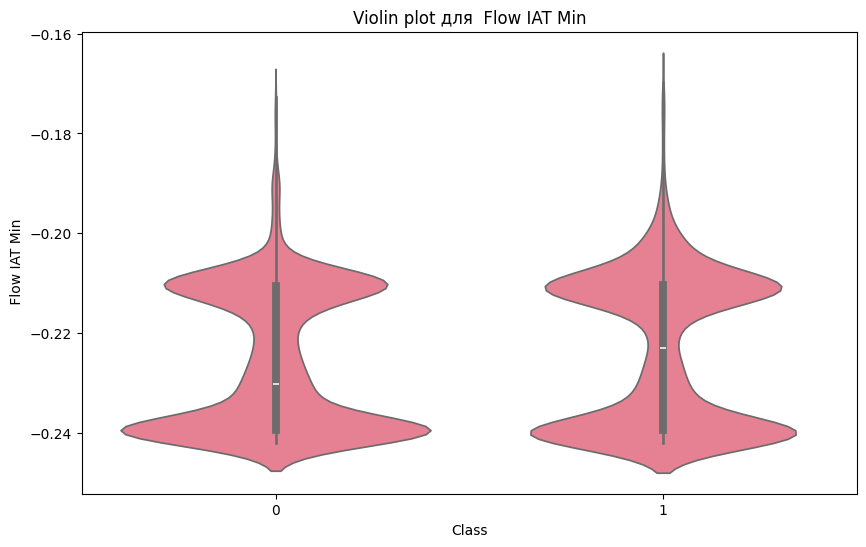

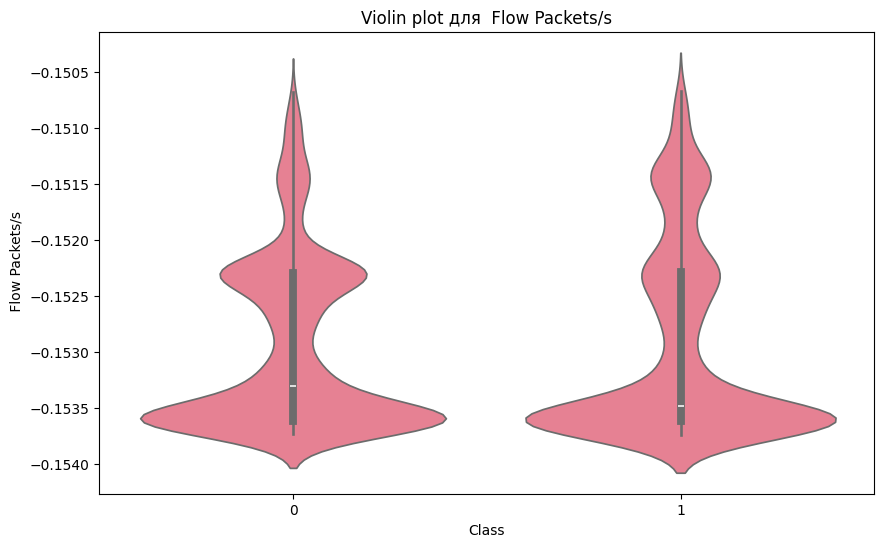

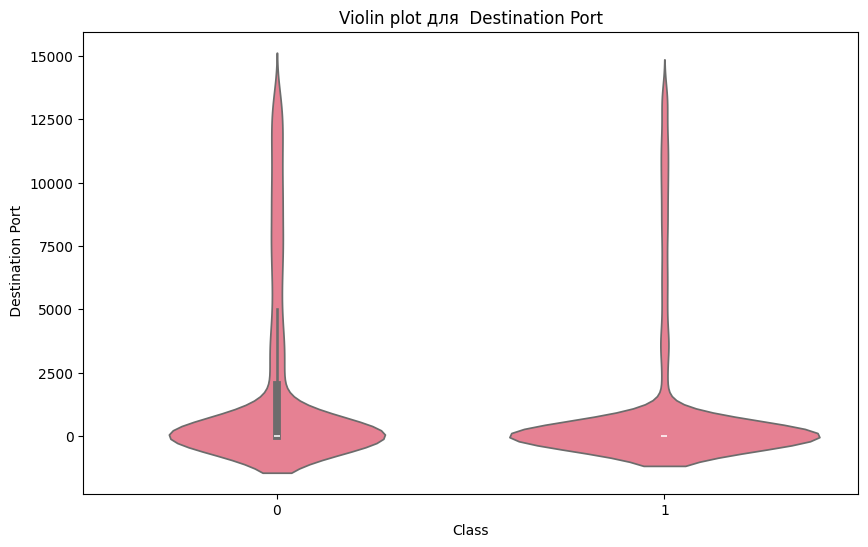

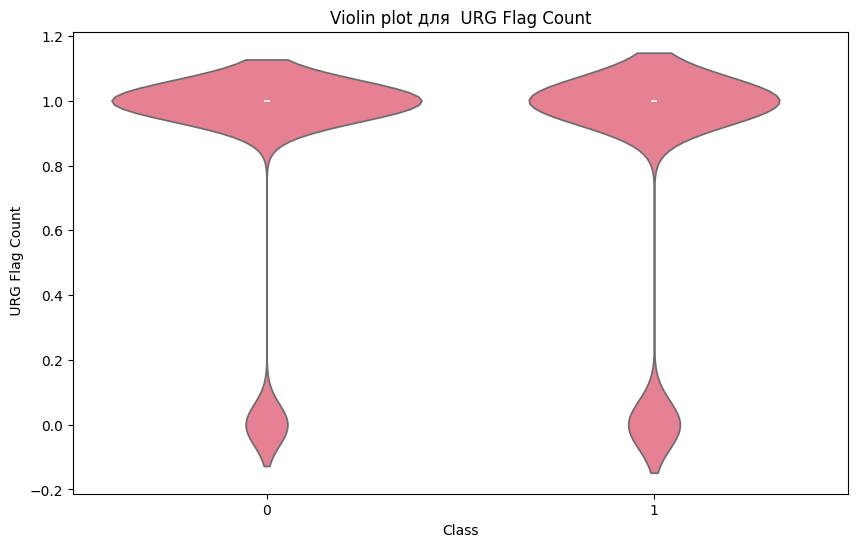

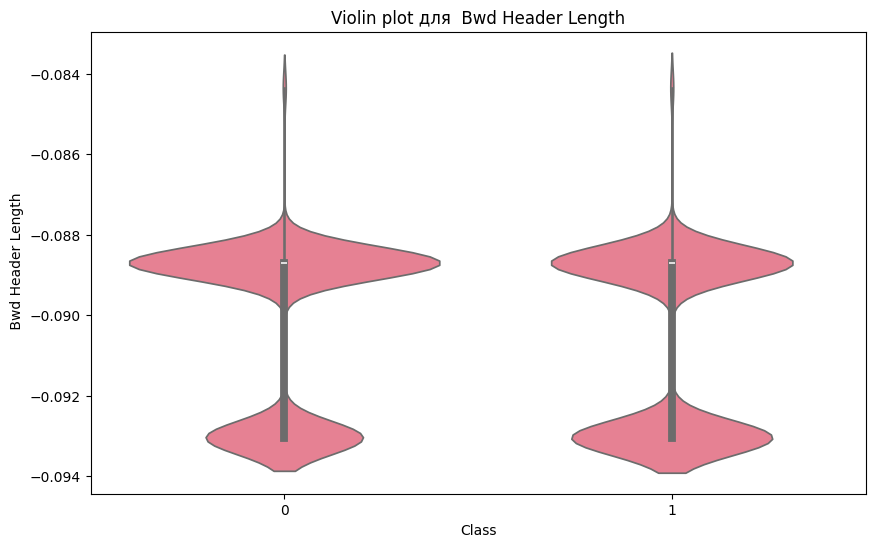

In [431]:
features = dataset.columns.drop('Class')

# Создание графиков
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Class', y=feature, data=df)
    plt.title(f'Violin plot для {feature}')
    plt.show()

Далее необходимо:
1) разделить датасет
2) обучить модели классификации
3) применить кросс-валидацию
4) построить ROC-кривые
5) посмотреть матрицу ошибок
6) выбрать лучшую модель

### Обучение моделей



Разделяем датасет

In [432]:
y = dataset['Class']                  # Целевая переменная
X = dataset.drop(columns=['Class'])  # Все колонки кроме 'Class'

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [433]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [434]:
# создаем лист для тех моделей, которые будем изучать
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=5000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier()))

# Обучение и вывод результатов
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Модель: {name}")
    print(f"Точность: {accuracy:.4f}")
    print(f"Отчет:\n{pd.DataFrame(report).transpose()}\n")

Модель: LR
Точность: 0.5539
Отчет:
              precision    recall  f1-score      support
0              0.585278  0.469065  0.520767   695.000000
1              0.531726  0.644615  0.582754   650.000000
accuracy       0.553903  0.553903  0.553903     0.553903
macro avg      0.558502  0.556840  0.551760  1345.000000
weighted avg   0.559398  0.553903  0.550723  1345.000000

Модель: LDA
Точность: 0.5792
Отчет:
              precision    recall  f1-score      support
0              0.610635  0.512230  0.557121   695.000000
1              0.555118  0.650769  0.599150   650.000000
accuracy       0.579182  0.579182  0.579182     0.579182
macro avg      0.582876  0.581500  0.578135  1345.000000
weighted avg   0.583805  0.579182  0.577432  1345.000000

Модель: KNN
Точность: 0.7182
Отчет:
              precision    recall  f1-score      support
0              0.723796  0.735252  0.729479   695.000000
1              0.712050  0.700000  0.705974   650.000000
accuracy       0.718216  0.718216  0

Обучаем модели для классификации

In [435]:


# Определите список моделей с их гиперпараметрами
models = []
params = {
    'GBC': {
        'model': GradientBoostingClassifier(),
        'param': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7, 9]
        }
    },
    'RFC': {
        'model': RandomForestClassifier(),
        'param': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'CART': {
        'model': DecisionTreeClassifier(),
        'param': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    }
}

best_models = {}

# Перебор моделей и применение GridSearchCV
for name, model_params in params.items():
    model = model_params['model']
    param_grid = model_params['param']

    grid_search_model = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=3,
                               verbose=3,
                               n_jobs=-1)

    grid_result = grid_search_model.fit(X_train, y_train)
    best_models[name] = grid_search_model.best_estimator_
    # Вывод результатов
    print(f"{name}: Best Score: {grid_result.best_score_}, Best Params: {grid_result.best_params_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
GBC: Best Score: 0.8283428611266035, Best Params: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
RFC: Best Score: 0.7993307098703953, Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
KNN: Best Score: 0.7396312627811862, Best Params: {'n_neighbors': 7, 'weights': 'distance'}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
CART: Best Score: 0.8032366486402145, Best Params: {'max_depth': 10, 'min_samples_split': 2}


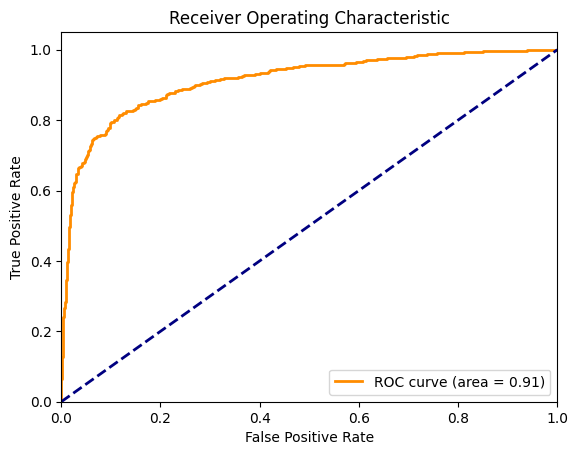

In [436]:
from sklearn.metrics import roc_curve, auc

y_scores = best_models["GBC"].predict_proba(X_test)[:, 1]

# Рассчитываем значения для ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Вычисляем площадь под кривой (AUC)
roc_auc = auc(fpr, tpr)

# Строим ROC кривую
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

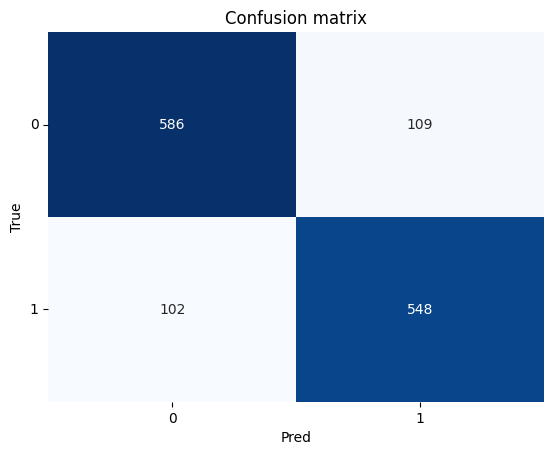

In [437]:
predicted = best_models["GBC"].predict(X_test).astype('int32')

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
'''
построим график

'''

plt.show()